# **Importing required libraries**



*   Loading dataset
*   Mounting onto Google Drive



In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla

In [ ]:
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
import pandas as pd
worksheet = gc.open('mrtJourneys').sheet1

# **Data Pre-Processing**



*   Creating adjacency matrix
*   Creating weighted edge list
*   Calculating average number of passengers traveling between each station
*   Calculatin the number of connected components using the Eigenvalues from the graph's Laplacian matrix

In [ ]:
rows = worksheet.get_all_values()
df = pd.DataFrame(rows)
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

In [ ]:
df_time = df.drop(columns=['commuter', 'Gender', 'Occupation']) # Removing other columns
df_time = df_time.replace("null", np.nan) # Removing null values
df_time = df_time.astype('Int64')

In [ ]:
df_time.head()

,0602hr,0604hr,0606hr,0608hr,0610hr,0612hr,0614hr,0616hr,0618hr,0620hr,0622hr,0624hr,0626hr,0628hr,0630hr,0632hr,0634hr,0636hr,0638hr
1,37,31,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,46,40,34,35,41,47,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,36,30,24,18,12,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,5,11,12,18,24,30,36,42,48,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,43,49,50,44,38,32,26,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
# Creating adjacency matrix of stations based on the timestamp information
rows = 54
total = 0
A = [[0 for j in range(rows)] for i in range(rows)]
A = np.array(A)
A_weights = [[0 for j in range(rows)] for i in range(rows)]
A_weights = np.array(A_weights)


for i in range(len(df_time)):
    for j in range(len(df_time.columns)-1):
        s1 = df_time.iloc[i,j]
        s2 = df_time.iloc[i,j+1]
        if isinstance(s1, np.int64) & isinstance(s2, np.int64):
            A[s1-1][s2-1] = 1
            A[s2-1][s1-1] = 1
            A_weights[s1-1][s2-1] += 1
            total += 1

In [ ]:
num_edges = 0

for i in range(len(A)):
  for j in range(len(A)):
    if A[i][j] != 0:
      num_edges += 1

average = total / num_edges
print(f'The average number of passengers traveling between each station, i.e. the average edge weight is {round(average, 0)}')

The average number of passengers traveling between each station, i.e. the average edge weight is 4273.0


In [ ]:
int2label = {}
for index in range(len(A_weights)):
  int2label[index] = index + 1

In [ ]:
# Plotting the network using networkx

G_ = nx.MultiDiGraph()
G_.add_nodes_from(range(0, 54))

for i in range(rows):
  for j in range(rows):
    if A_weights[i][j] != 0:
      G_.add_edge(i, j, weight=A_weights[i][j])

# Assigning edge colors - allows us to visualize the traveling trends
edge_colors = ['green' if edge[2]['weight'] <= average else 'red' for edge in G_.edges(data=True)]

G = nx.relabel_nodes(G_, int2label)

In [ ]:
laplacian = nx.normalized_laplacian_matrix(nx.Graph(G))

In [ ]:
eigenvalues = np.linalg.eigvals(laplacian.A) # .A is shorthand for .toarray()

/usr/local/lib/python3.9/dist-packages/scipy/sparse/_base.py:752: VisibleDeprecationWarning: Please use `.todense()` instead
  warn(np.VisibleDeprecationWarning(


Finding the number of zero eigenvalues in the graph's Laplacian matrix to find the number of connected components

In [ ]:
connected_components = 0
for eigenvalue in eigenvalues:
  if eigenvalue < 10**(-16):
    connected_components +=1

print(f"Using the eigenvalues of the Graph Laplacian matrix, we find that the number of connected components is {connected_components}")

Using the eigenvalues of the Graph Laplacian matrix, we find that the number of connected components is 2


As can be seen from our findings above, there are 2 connected components

# **Objective 1**

Identifying edges with a higher number of passengers


*   Are there stations that would reap higher benefits from having a higher frequency of trains?
*   Which stations have lower foot-fall -> could some manpower be redirected from these stations to "busier" stations?




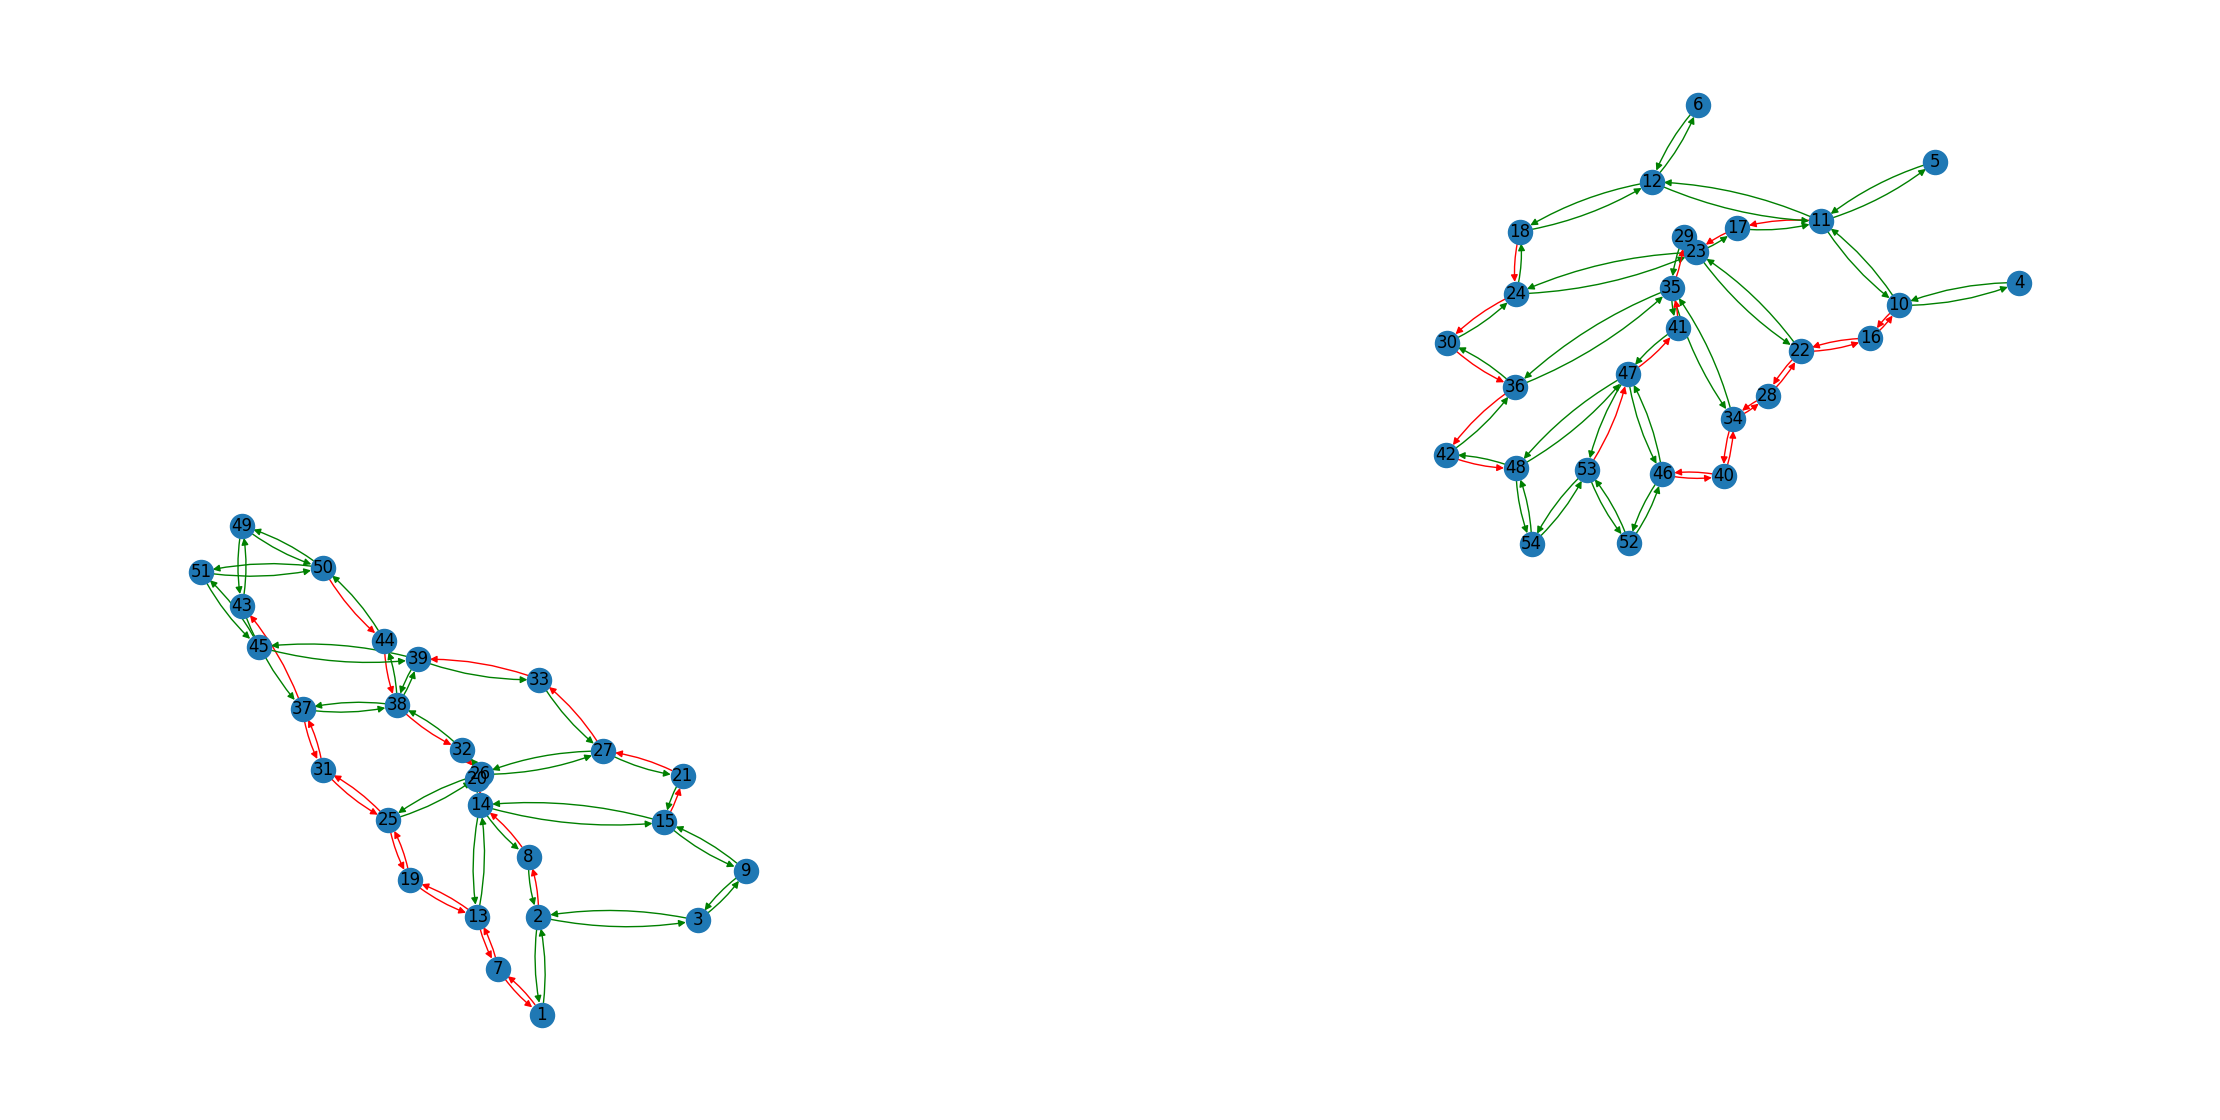

In [ ]:
pos = nx.spring_layout(G, scale=7) # Seed for replicability
plt.figure(3,figsize=(22,11))
nx.draw(G, pos, connectionstyle='arc3, rad = 0.1', edge_color=edge_colors, with_labels=True)
plt.show()

Based on the Network graph created using Networkx, we can observe 2 connected components.

Additionally, we can observe from the graph alone that edges with high foot-fall appear to cluster together - there are not any edges between stations with high foot-fall that are far away from all other edges with high foot-fall.

Interestingly, some edges have high foot-fall when the reverse edge does not.



To better visualize the identification of high/low passenger edges, we perform our analysis on the 2 connected components separately

In [ ]:
# First, identify the nodes in each component

nodes = list(range(1, 55))
components = []
for component in nx.strongly_connected_components(G.subgraph(nodes)):
  components.append(component)

for index in range(1,3):
  component = components[index-1]
  print(f'Set of nodes in component {index}: {component}')

Set of nodes in component 1: {1, 2, 3, 7, 8, 9, 13, 14, 15, 19, 20, 21, 25, 26, 27, 31, 32, 33, 37, 38, 39, 43, 44, 45, 49, 50, 51}
Set of nodes in component 2: {4, 5, 6, 10, 11, 12, 16, 17, 18, 22, 23, 24, 28, 29, 30, 34, 35, 36, 40, 41, 42, 46, 47, 48, 52, 53, 54}


## Component 1

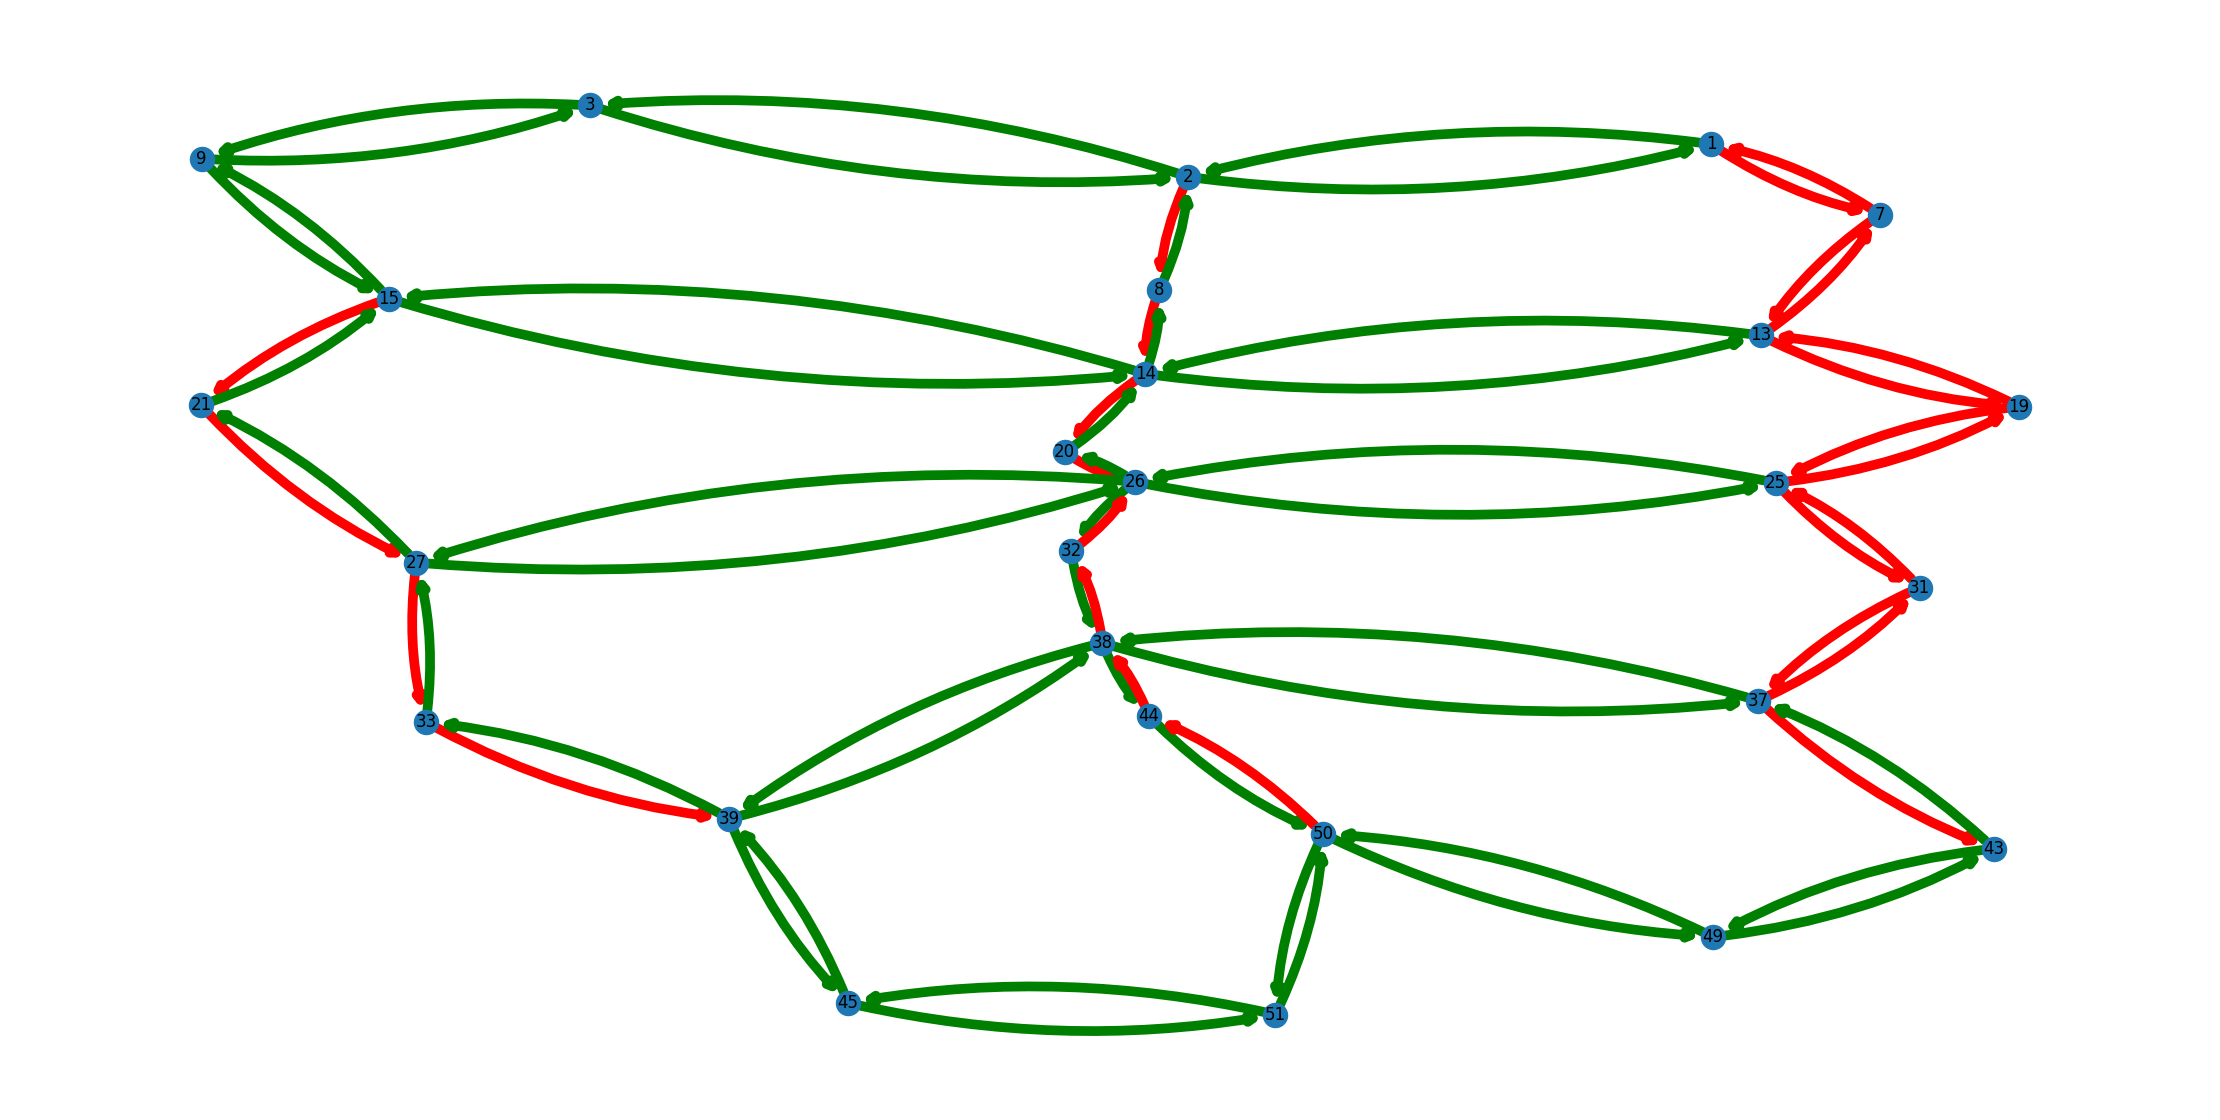

In [ ]:
G_1 = G.subgraph(list(components[0]))

# Plotting the component 1 subgraph
edge_colors = ['green' if edge[2]['weight'] <= average else 'red' for edge in G_1.edges(data=True)]

pos = nx.spring_layout(G_1, scale=7)
plt.figure(3,figsize=(22,11))
nx.draw(G_1, pos, connectionstyle='arc3, rad = 0.1', edge_color=edge_colors, with_labels=True, width=7)
plt.show()

In [ ]:
import copy as cp
copy = nx.MultiDiGraph(G_1)
for edge in G_1.edges(data=True):
  if edge[2]['weight'] <= average:
    copy.remove_edge(edge[0], edge[1])

In [ ]:
# Assigning G_1 back to the (unfrozen) copy graph
G_1 = copy

Now that we have removed all the 'green' edges with below average number of passengers, we will be left only with the directed edges with a high number of passengers. Plotting this below, we get a network containing only 'red' edges.

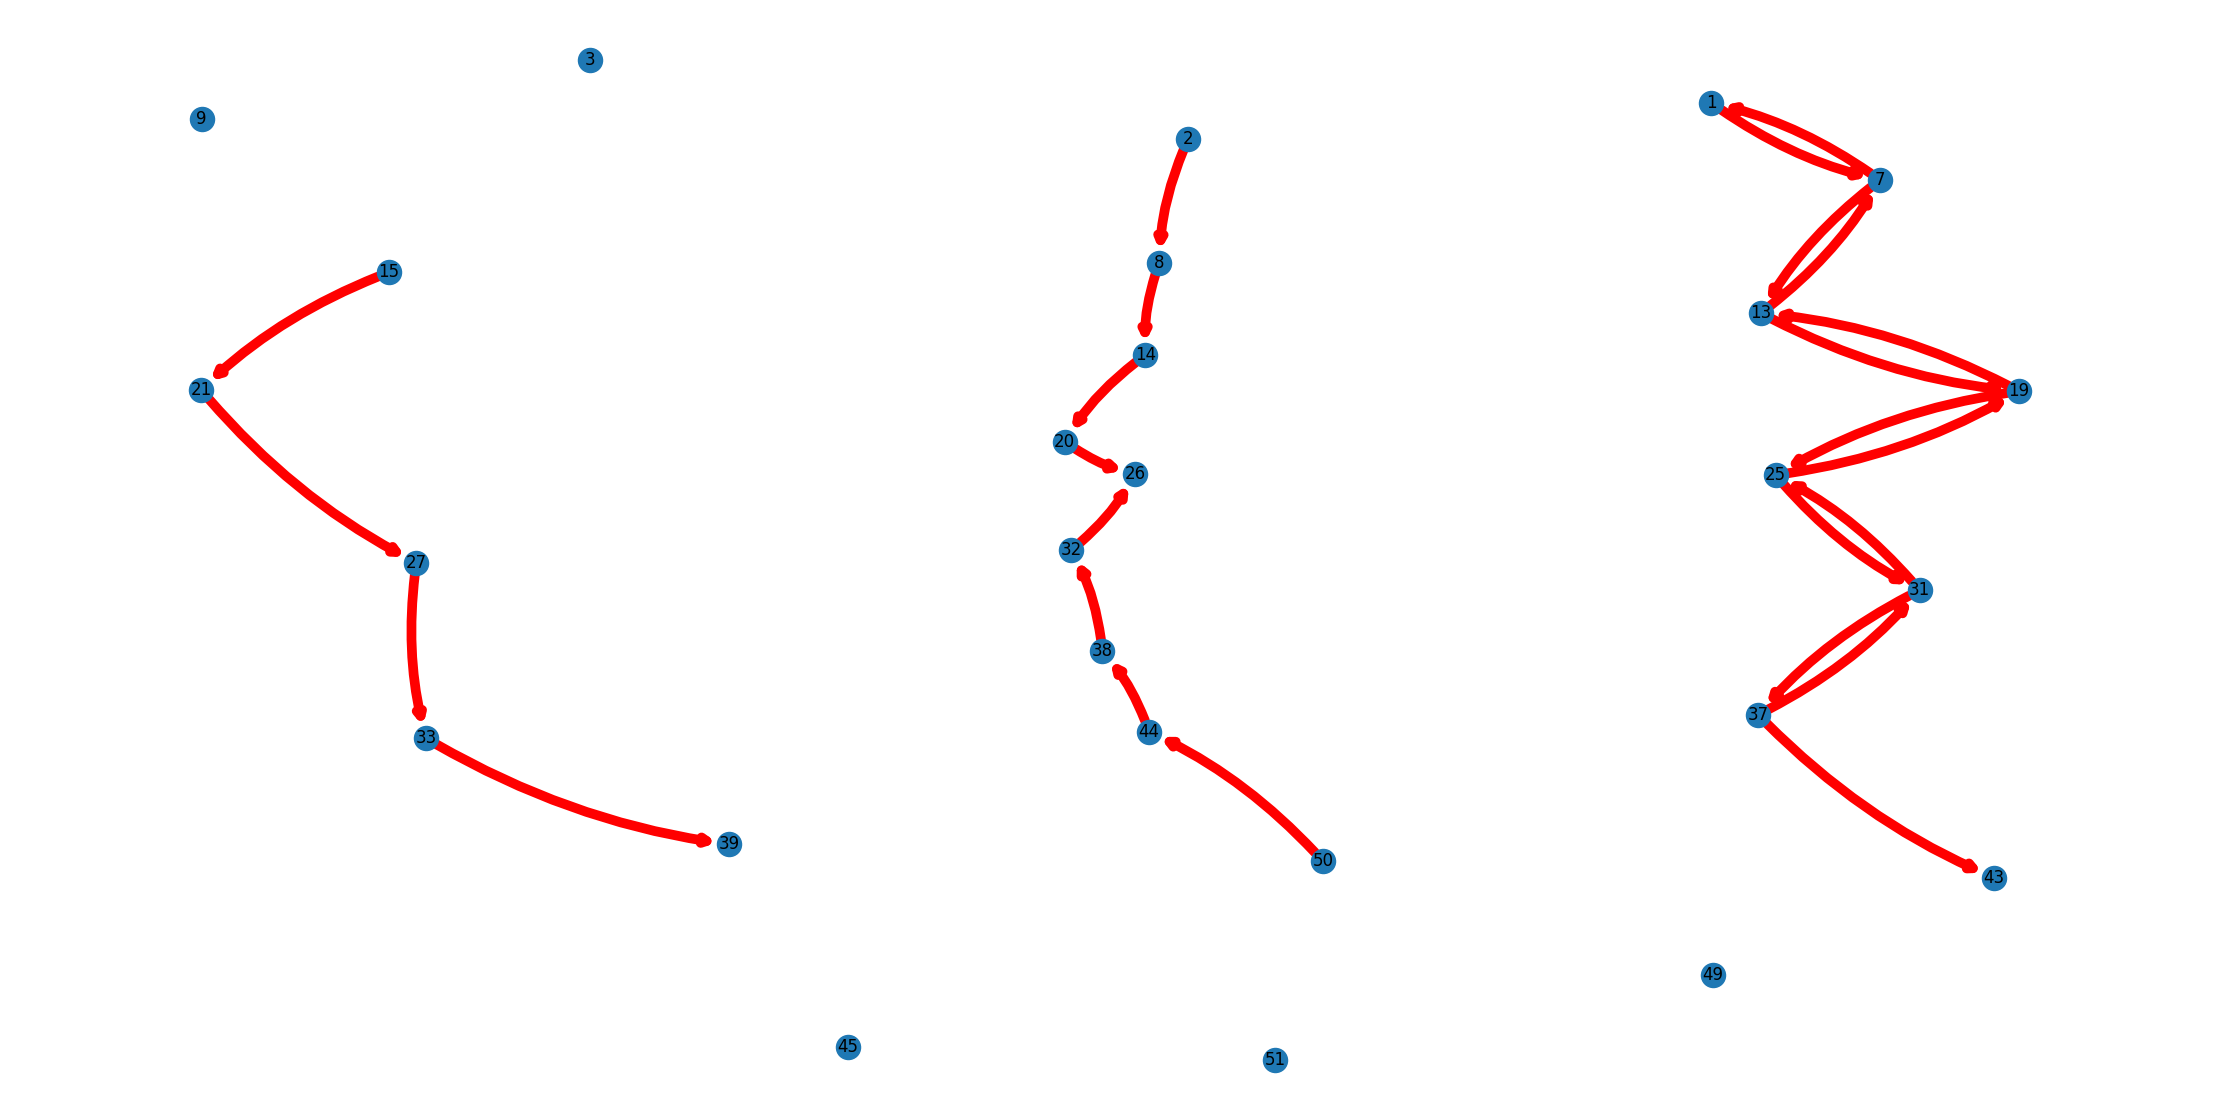

In [ ]:
plt.figure(3,figsize=(22,11))
edge_colors = ['green' if edge[2]['weight'] <= average else 'red' for edge in G_1.edges(data=True)]
nx.draw(G_1, pos, connectionstyle='arc3, rad = 0.1', edge_color=edge_colors, with_labels=True, width=7)
plt.show()

Based on this network, we observe some information:

Some stations become completely isolated from the network: Indicative of stations with edges that have low number of passengers. These are likely places with low number of residents around the area, meaning less number of people boarding in the morning to go to work. We identify these stations in the code snippet below:

In [ ]:
nodes = list(components[0])
components_1 = []
single_node_components = []
for component in nx.connected_components(nx.Graph(G_1)):
  components_1.append(component)

for index in range(1,len(components_1) + 1):
  component = components_1[index-1]
  if len(component) == 1:
    single_node_components.append(list(component)[0])

print(f'Stations with low incoming and outgoing passengers: {single_node_components}')

Stations with low incoming and outgoing passengers: [3, 9, 45, 49, 51]


Based on the information discovered in component 1, we believe SMRT/SBST could improve the overall transport experience by redirecting some trains that begin their service at these stations to instead start at other high foot-fall stations, reducing the waiting time between trains at morning peak hours.

Whilst we could say that SMRT/SBST should increase the frequency of trains at all the other stations not included in the above set, we should go one level deeper - whilst all of these remaining directed edges are above the global (network) average, there may still be big differences in passenger numbers among these edges. Below, we go one level deeper:

<ipython-input-708-187f28721be0>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(G_1, pos, connectionstyle='arc3, rad = 0.1', edge_color=weights, with_labels=True, edge_cmap=plt.cm.get_cmap('Reds'), width=7)


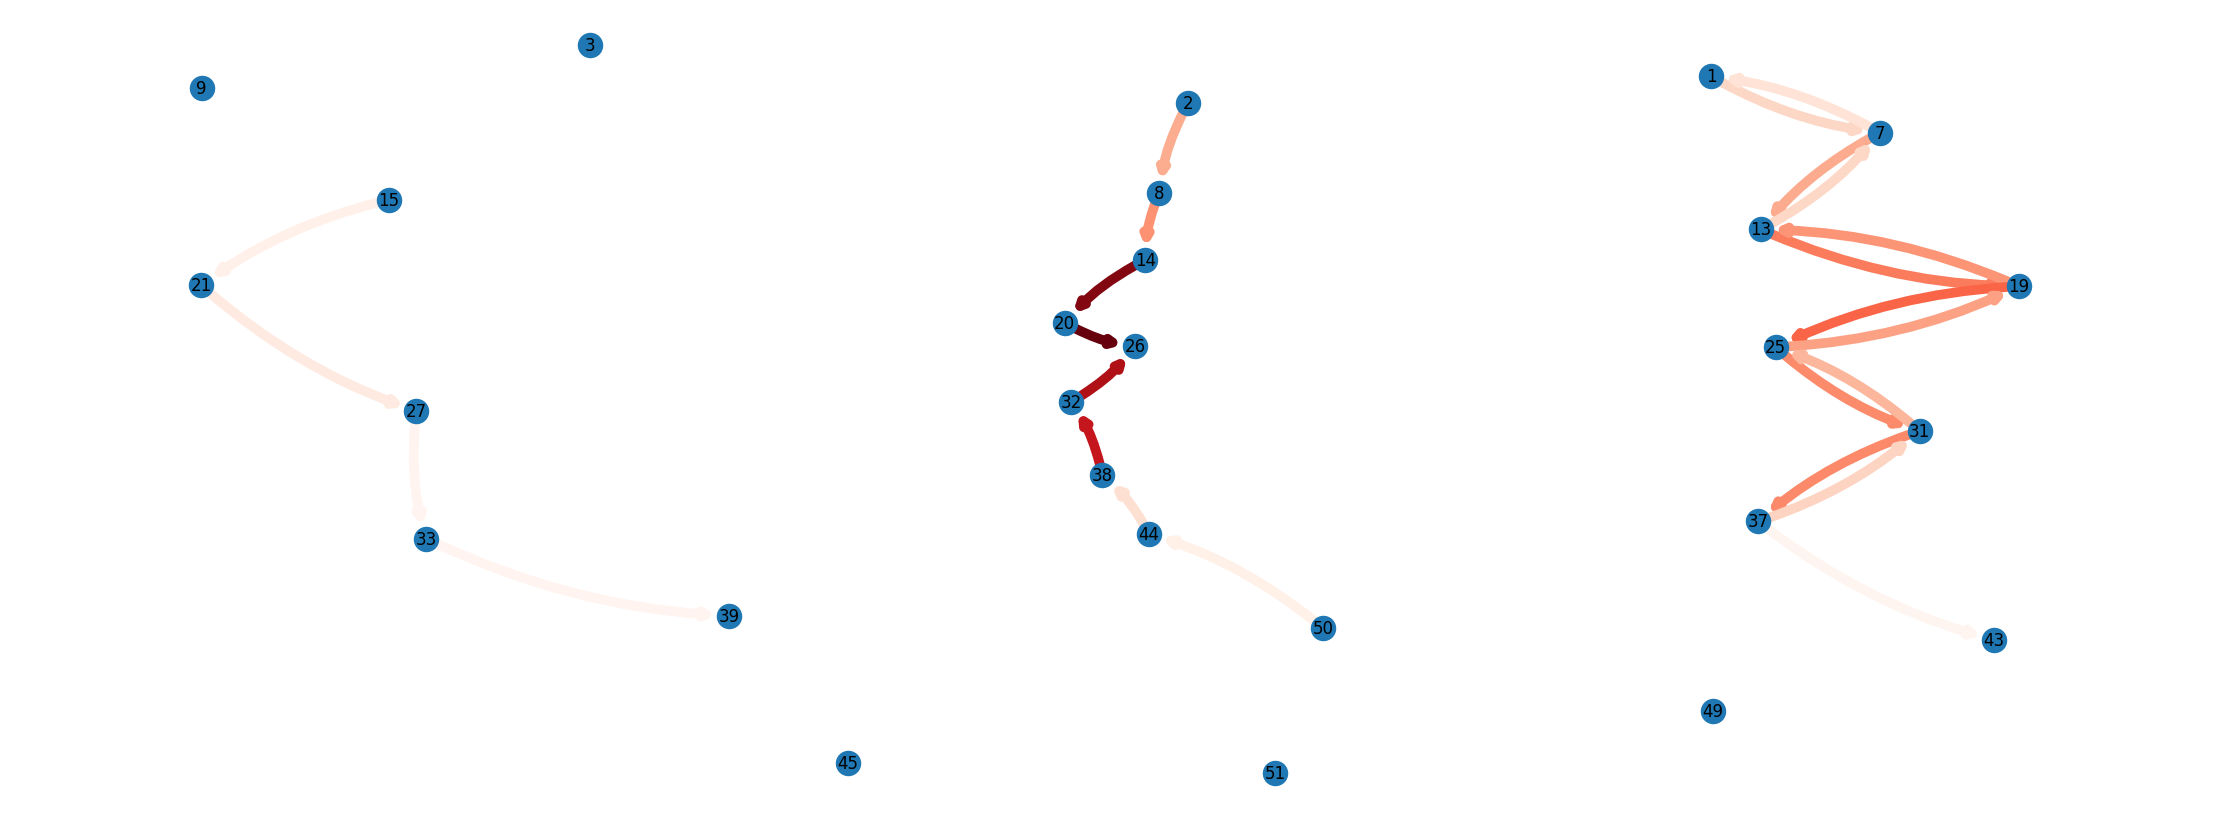

In [ ]:
edges,weights = zip(*nx.get_edge_attributes(G_1,'weight').items())

plt.figure(3,figsize=(22,8))
nx.draw(G_1, pos, connectionstyle='arc3, rad = 0.1', edge_color=weights, with_labels=True, edge_cmap=plt.cm.get_cmap('Reds'), width=7)
plt.show()

As evidenced from our network findings, we see that some edges do in fact have (significantly) higher passenger transport numbers than others, even amongst a set of edges that all have above average numbers. We see that stations 14,20,26,32, and 38 in particular experiences very high foot-fall.

We propose that SMRT/SBST could look into redirecting manpower and trains from stations with low number of foot-fall to stations such as those, and to a lesser extent redirecting some manpower and stations to the other stations that are also slightly above average in passenger count.

## Component 2

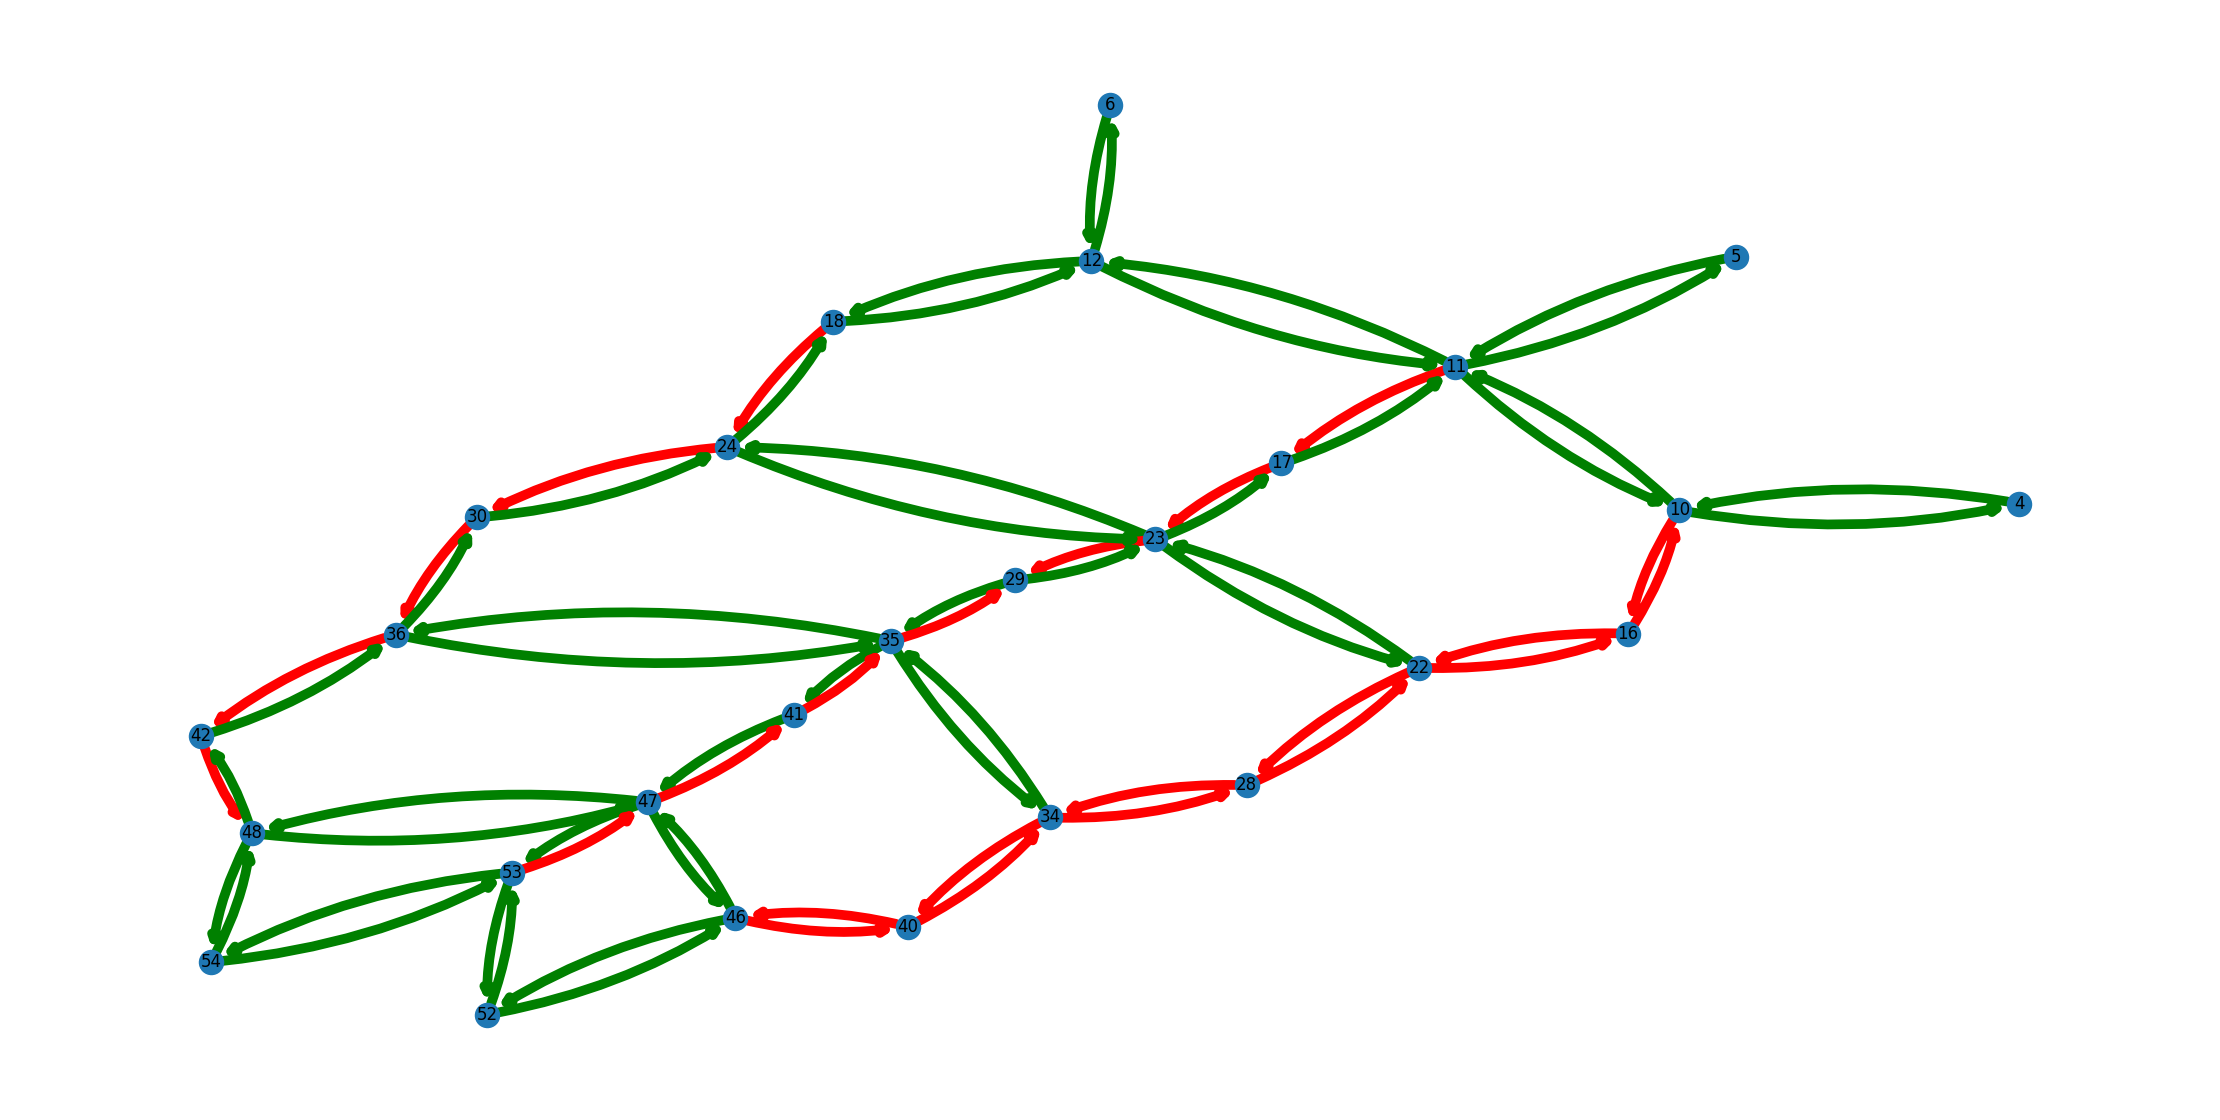

In [ ]:
G_2 = G.subgraph(list(components[1]))

# Plotting the component 1 subgraph
edge_colors = ['green' if edge[2]['weight'] <= average else 'red' for edge in G_2.edges(data=True)]

pos = nx.spring_layout(G_2, scale=7, seed=55) # Seed for replicability
plt.figure(3,figsize=(22,11))
nx.draw(G_2, pos, connectionstyle='arc3, rad = 0.1', edge_color=edge_colors, with_labels=True, width=7)
plt.show()

In [ ]:
copy = nx.MultiDiGraph(G_2)
for edge in G_2.edges(data=True):
  if edge[2]['weight'] <= average:
    copy.remove_edge(edge[0], edge[1])

In [ ]:
# Assigning G_1 back to the (unfrozen) copy graph
G_2 = copy

Now that we have removed all the 'green' edges with below average number of passengers, we will be left only with the directed edges with a high number of passengers. Plotting this below, we get a network containing only 'red' edges.

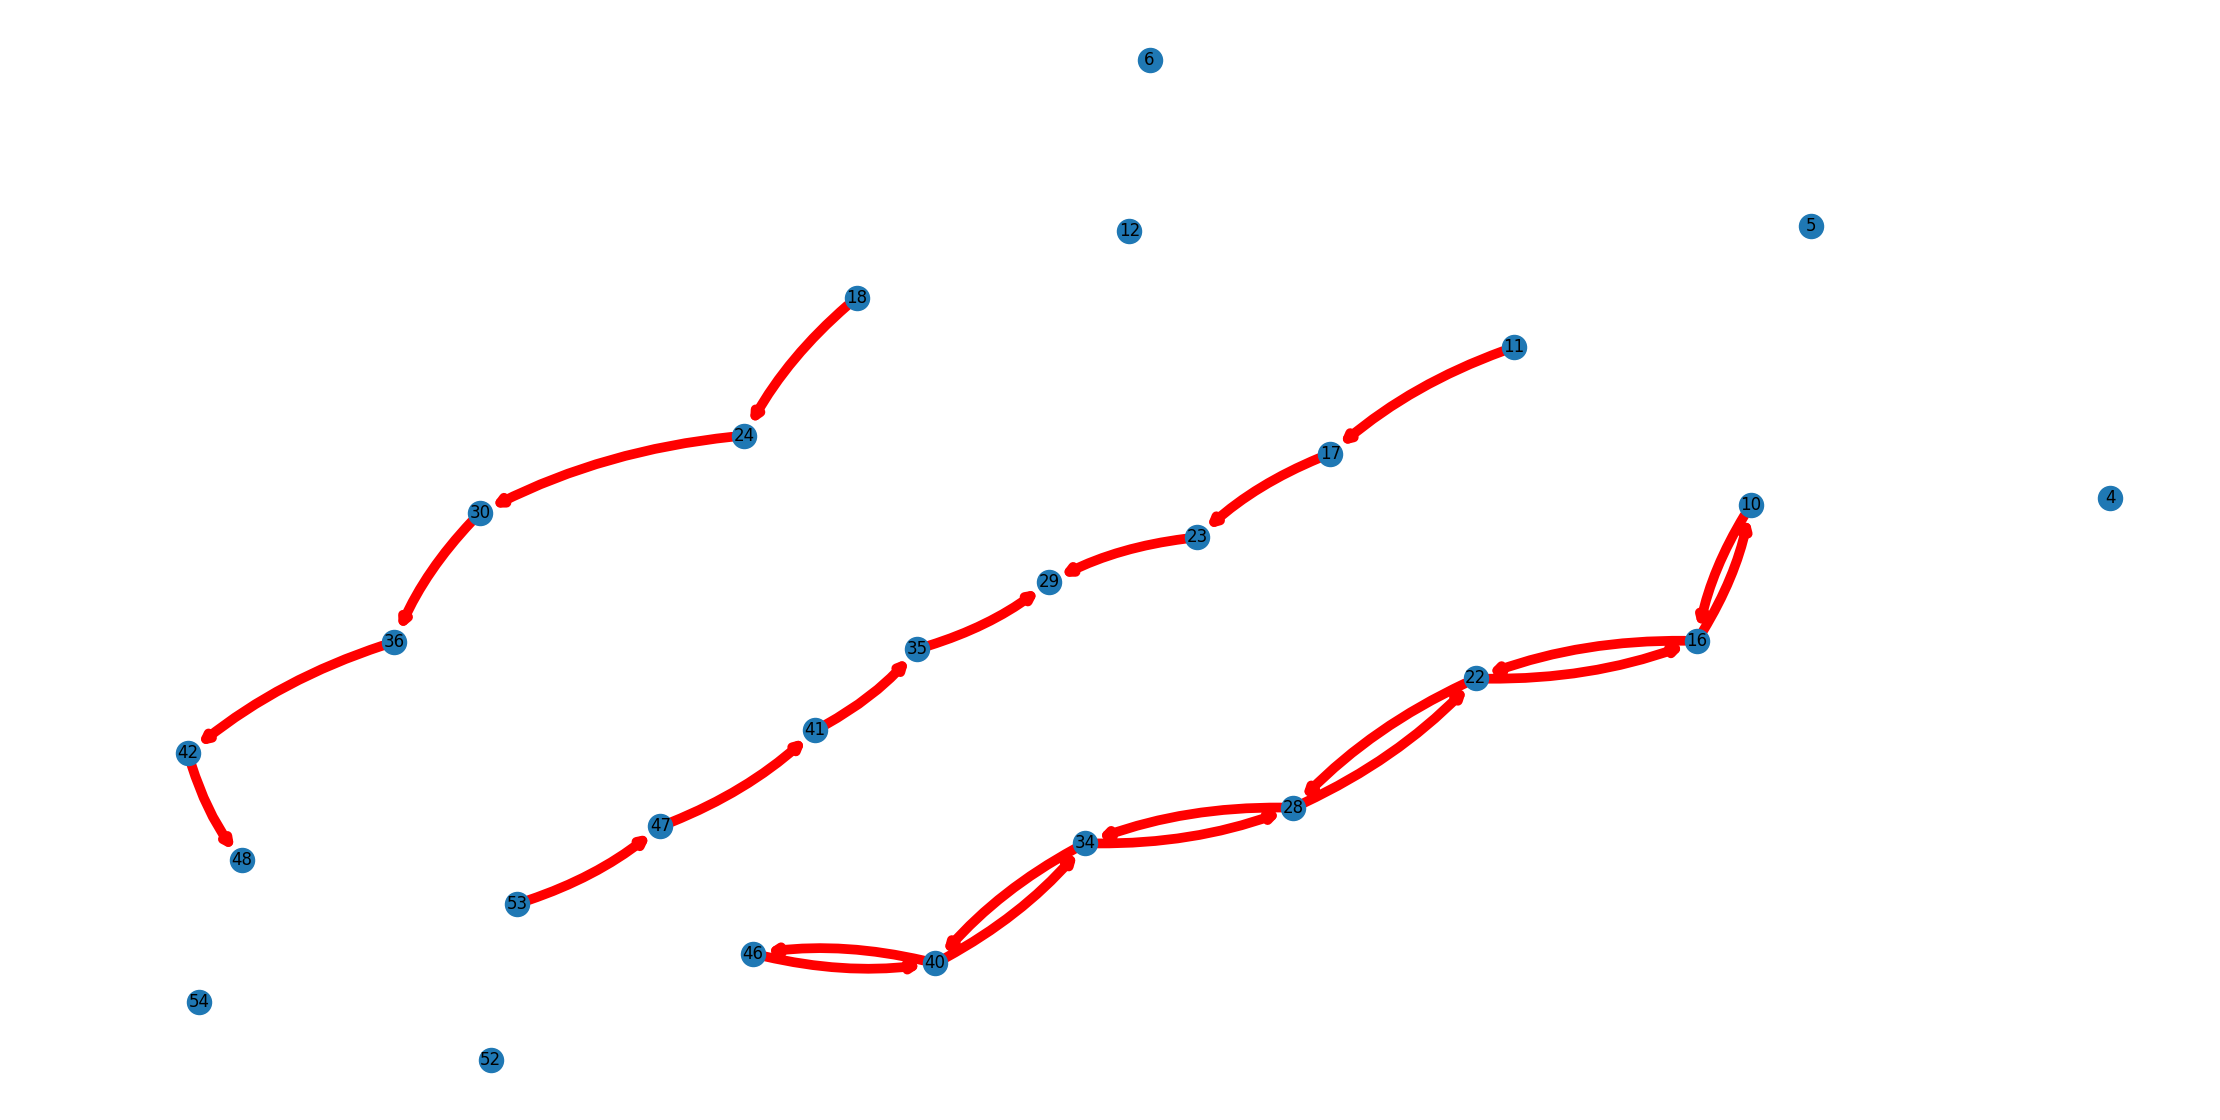

In [ ]:
plt.figure(3,figsize=(22,11))
edge_colors = ['green' if edge[2]['weight'] <= average else 'red' for edge in G_2.edges(data=True)]
nx.draw(G_2, pos, connectionstyle='arc3, rad = 0.1', edge_color=edge_colors, with_labels=True, width=7)
plt.show()

Much like component 1, we observe some similar traits:


*   Some stations completely isolated from the network: Indicative of stations with edges that have low number of passengers
*   Only 'red' edges in the network

In [ ]:
nodes = list(components[0])
components_2 = []
single_node_components = []
for component in nx.connected_components(nx.Graph(G_2)):
  components_2.append(component)

for index in range(1,len(components_2) + 1):
  component = components_2[index-1]
  if len(component) == 1:
    single_node_components.append(list(component)[0])

print(f'Stations with low incoming and outgoing passengers: {single_node_components}')

Stations with low incoming and outgoing passengers: [4, 5, 6, 12, 52, 54]


Based on the information discovered in component 1, we believe SMRT/SBST could improve the overall transport experience by redirecting some trains that begin their service at these stations to instead start at other high foot-fall stations, reducing the waiting time between trains at morning peak hours.

Whilst we could say that SMRT/SBST should increase the frequency of trains at all the other stations not included in the above set, we should go one level deeper - whilst all of these remaining directed edges are above the global (network) average, there may still be big differences in passenger numbers among these edges. Below, we go one level deeper:

<ipython-input-714-d8258e967e28>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(G_2, pos, connectionstyle='arc3, rad = 0.1', edge_color=weights, with_labels=True, edge_cmap=plt.cm.get_cmap('Reds'), width=7)


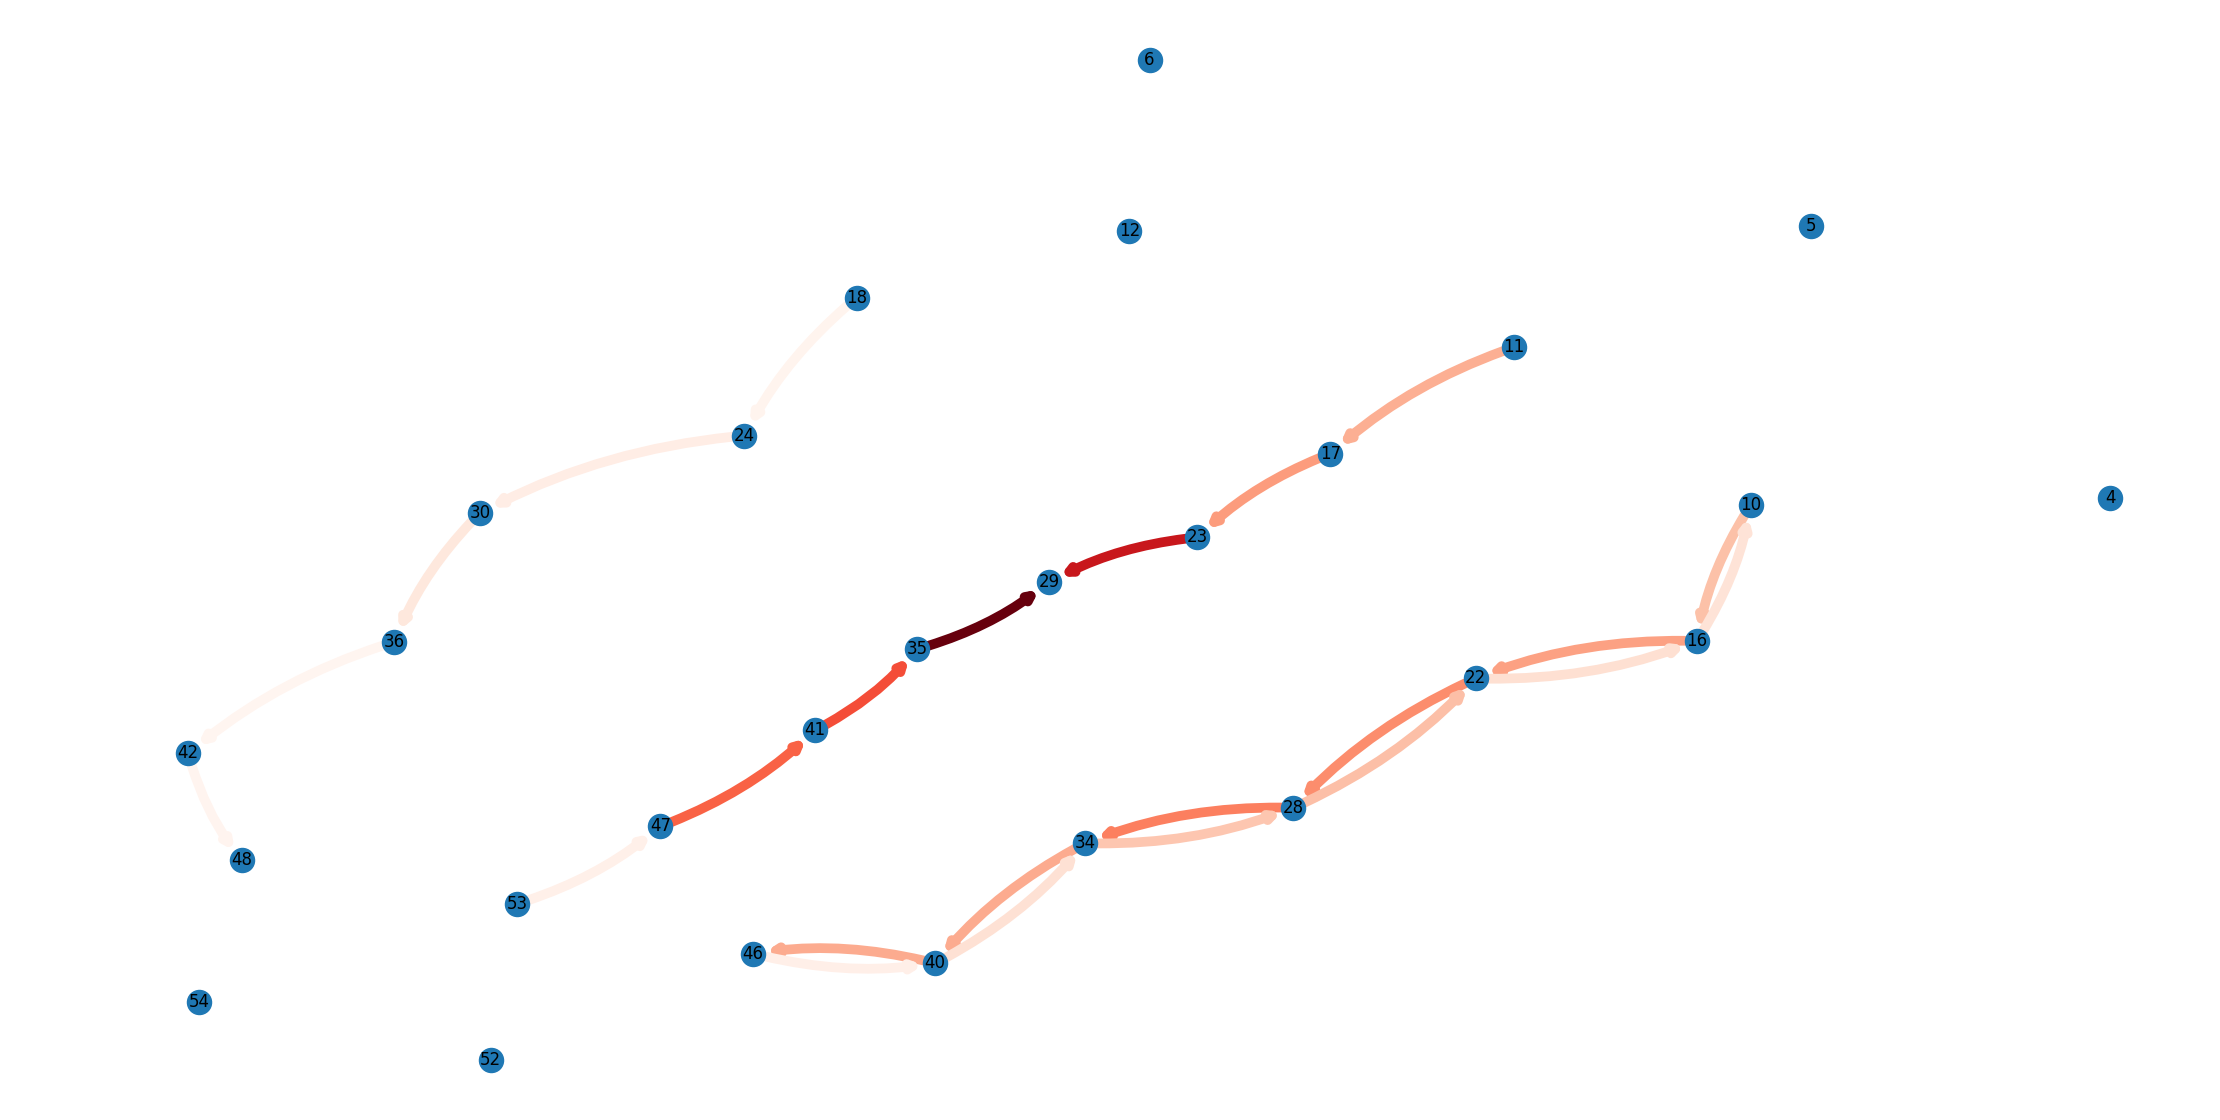

In [ ]:
edges,weights = zip(*nx.get_edge_attributes(G_2,'weight').items())

plt.figure(3,figsize=(22,11))
nx.draw(G_2, pos, connectionstyle='arc3, rad = 0.1', edge_color=weights, with_labels=True, edge_cmap=plt.cm.get_cmap('Reds'), width=7)
plt.show()

Here, we make some observations. Much like network 1, we see that some edges do in fact have (significantly) higher passenger transport numbers than others, even amongst a set of edges that all have above average numbers. We see that stations 47, 41, 35, 29, and 23 in particular experiences very high foot-fall.

We propose that SMRT/SBST could look into redirecting manpower and trains from stations with low number of foot-fall to stations such as those, and to a lesser extent redirecting some manpower and stations to the other stations that are also slightly above average in passenger count.

# **Objective 2**

Identifying journies that traverse a high number of stations

*   What are the trends we can detect by performing feature engineering on the dataset and through EDA?
*   Can we use network analysis to shorten these journies or improve the transport experience of these passengers in some way?
*   Can we use the Laplacian matrix to identify the most optimal ways to add links to shorten the journeys of these passengers?



To begin, we will use the average number of stations traversed as a starting benchmark

In [ ]:
df.head(3)

,commuter,0602hr,0604hr,0606hr,0608hr,0610hr,0612hr,0614hr,0616hr,0618hr,...,0624hr,0626hr,0628hr,0630hr,0632hr,0634hr,0636hr,0638hr,Gender,Occupation
1,1,37,31,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,male,politician
2,2,46,40,34,35,41,47,null,null,null,...,null,null,null,null,null,null,null,null,female,politician
3,3,36,30,24,18,12,6,null,null,null,...,null,null,null,null,null,null,null,null,female,politician


In [ ]:
df.shape

(100000, 22)

In [ ]:
df_time['Stations'] = np.nan
for row in range(df_time.shape[0]):
  num_stations = 0
  for column in range(0, df_time.shape[1]):
    value = df_time.iloc[row, column]
    if isinstance(value, np.int64):
      num_stations += 1
    else: # End of the journey
      df_time['Stations'].iloc[row] = num_stations
      break

<ipython-input-717-09dc3e301922>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['Stations'].iloc[row] = num_stations


In [ ]:
df_time = pd.concat([df_time, df[['commuter', 'Gender', 'Occupation']]], axis=1)

In [ ]:
average_stations = df_time['Stations'].mean()
print(f'The average number of stations traveled is {average_stations} stations')

The average number of stations traveled is 6.8115 stations


We find the average number of stations traversed to be about 6.81 stations. We will filter for passengers who unfortunately have to travel more than this average number, and find some trends amongst these passengers.

In [ ]:
df_filtered = df_time[df_time['Stations'] > average_stations]
df_filtered.reset_index(inplace=True, drop=True)
df_filtered.head(3)

,0602hr,0604hr,0606hr,0608hr,0610hr,0612hr,0614hr,0616hr,0618hr,0620hr,...,0628hr,0630hr,0632hr,0634hr,0636hr,0638hr,Stations,commuter,Gender,Occupation
0,5,11,12,18,24,30,36,42,48,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,9.0,4,female,politician
1,43,49,50,44,38,32,26,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7.0,5,male,worker
2,46,40,34,28,22,16,10,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7.0,6,female,worker


In [ ]:
df_time['Occupation'].value_counts()

worker        45079
politician    32615
student       22306
Name: Occupation, dtype: int64

In [ ]:
df_filtered['Occupation'].value_counts()

worker        22162
politician    14883
student        9137
Name: Occupation, dtype: int64

In [ ]:
worker_proportion = df_filtered['Occupation'].value_counts()['worker'] / df_time['Occupation'].value_counts()['worker']
politician_proportion = df_filtered['Occupation'].value_counts()['politician'] / df_time['Occupation'].value_counts()['politician']
student_proportion = df_filtered['Occupation'].value_counts()['student'] / df_time['Occupation'].value_counts()['student']

print(f'Proportion of workers traveling longer than average journies is {worker_proportion}')
print(f'Proportion of politicians traveling longer than average journies is {politician_proportion}')
print(f'Proportion of students traveling longer than average journies is {student_proportion}')

Proportion of workers traveling longer than average journies is 0.4916258124625657
Proportion of politicians traveling longer than average journies is 0.4563237774030354
Proportion of students traveling longer than average journies is 0.40962072984847125


What we see is that workers are the occupation most commonly associated with longer journies, with students traveling the least. We verify this by calculating the proportion of workers/politicians/students that trevel longer than average journies as the dataset is not evenly spread amongst these 3 proportions, and our initial findings are supported. This is reasonable.

Intuitively, we can assume students generally travel less since they have more of a 'choice' on the school they attend - many families would elect to choose schools nearest to their residence.

We perform further feature engineering to find the average traveling journies of each occupation, among travelers that are already traveling longer than the 'global' average

In [ ]:
worker_average = df_filtered[df_filtered['Occupation'] == 'worker']['Stations'].mean()
politican_average = df_filtered[df_filtered['Occupation'] == 'politician']['Stations'].mean()
student_average = df_filtered[df_filtered['Occupation'] == 'student']['Stations'].mean()

print(f'Average journey of workers that are already traveling longer than 6.81 stations is {worker_average}')
print(f'Average journey of politican that are already traveling longer than 6.81 stations is {politican_average}')
print(f'Average journey of student that are already traveling longer than 6.81 stations is {student_average}')

Average journey of workers that are already traveling longer than 6.81 stations is 9.916659146286436
Average journey of politican that are already traveling longer than 6.81 stations is 9.648995498219445
Average journey of student that are already traveling longer than 6.81 stations is 9.889241545365


What we see is that all of these passengers are almost equally affected in terms of number of stations traveled. We will plot the network with data only containing these affected individuals

In [ ]:
df_filtered.head(3)

,0602hr,0604hr,0606hr,0608hr,0610hr,0612hr,0614hr,0616hr,0618hr,0620hr,...,0628hr,0630hr,0632hr,0634hr,0636hr,0638hr,Stations,commuter,Gender,Occupation
0,5,11,12,18,24,30,36,42,48,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,9.0,4,female,politician
1,43,49,50,44,38,32,26,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7.0,5,male,worker
2,46,40,34,28,22,16,10,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7.0,6,female,worker


In [ ]:
df_filtered.shape

(46182, 23)

In [ ]:
df_filtered_time = df_filtered.drop(columns=['Stations', 'commuter', 'Gender', 'Occupation'])

In [ ]:
# Creating adjacency matrix of stations based on the timestamp information
rows = 54
total = 0
A_filtered = [[0 for j in range(rows)] for i in range(rows)]
A_filtered = np.array(A)
A_filtered_weights = [[0 for j in range(rows)] for i in range(rows)]
A_filtered_weights = np.array(A_filtered_weights)


for i in range(len(df_filtered_time)):
    for j in range(len(df_filtered_time.columns)-1):
        s1 = df_filtered_time.iloc[i,j]
        s2 = df_filtered_time.iloc[i,j+1]
        if isinstance(s1, np.int64) & isinstance(s2, np.int64):
            A_filtered[s1-1][s2-1] = 1
            A_filtered[s2-1][s1-1] = 1
            A_filtered_weights[s1-1][s2-1] += 1
            total += 1

In [ ]:
G_filtered = nx.MultiDiGraph()
G_filtered.add_nodes_from(range(0, 54))

for i in range(rows):
  for j in range(rows):
    if A_filtered_weights[i][j] != 0:
      G_filtered.add_edge(i, j, weight=A_filtered_weights[i][j])

# Assigning edge colors - allows us to visualize the traveling trends
edge_colors = ['green' if edge[2]['weight'] <= average else 'red' for edge in G_filtered.edges(data=True)]

#G_filtered = nx.relabel_nodes(G_filtered, int2label)

In this case, we are not concerned with the stations in the "middle" of these passengers' journeys. Instead, we will look to their start/end stations as well as stations that are 1/2/3 steps away from these start/end stations. The goal is to bring as many passengers' journeys <= current global network average of 6.8 stations.

In short, we will try to find a station that is at most 3 stops away from most of the starting points of these passengers, and make a direct link to a station that is at most 3 stops away from most of the ending points of these passengers, bringing the journey down to at most 6 stops, which is below the global network average.

To select the stations to choose from, we first look at the most common starting stations amongst these passengers. We will then highlight these stations on the network by coloring in the nodes

In [ ]:
start = {}
for row in range(df_filtered_time.shape[0]):
  station = df_filtered_time.iloc[row, 0]
  if station not in start.keys():
    start[station] = 1
  else:
    start[station] += 1

In [ ]:
# (key, value) pair where key is the starting station and value is the number of long journey passengers beginning their journey from there
start = dict(sorted(start.items(), key=lambda item: item[1], reverse=True))
start.items()

dict_items([(1, 2756), (4, 2304), (10, 2152), (37, 2128), (46, 2117), (13, 1883), (34, 1835), (22, 1799), (3, 1589), (25, 1470), (6, 1287), (12, 1265), (39, 1210), (43, 1150), (48, 1142), (15, 1094), (36, 1062), (24, 1034), (7, 960), (31, 959), (19, 902), (2, 881), (27, 873), (28, 868), (40, 831), (26, 767), (16, 707), (5, 688), (45, 595), (11, 565), (9, 561), (38, 561), (33, 537), (30, 525), (47, 522), (21, 517), (42, 485), (18, 437), (23, 422), (29, 420), (35, 414), (14, 412), (44, 334), (41, 271), (8, 238), (17, 234), (32, 227), (20, 192)])

In [ ]:
laplacian = nx.normalized_laplacian_matrix(nx.Graph(G_filtered)).toarray()
laplacian = np.dot(np.dot(laplacian, laplacian), laplacian) # We consider stops 3 steps away, i.e. L*L*L

In [ ]:
laplacian.shape # Sanity check

(54, 54)

We will now identify stations that we will use  -> first we add the most common starting station to a list called stations[]. Then, we slowly go through each of the stations in our starting stations list (retrieved from the key, value pairs in the dictionary). If it is 3 steps away from any one of the existing stations in stations[] then we move on to the next station, and so on.

In [ ]:
starting_stations = list(start.keys())
chosen_starting_stations = [starting_stations[0]]
for index in range(1, len(starting_stations)):
  starting_station = starting_stations[index]
  x = [0 for j in range(len(laplacian))]
  x[starting_station - 1] = 1
  neighbours = np.dot(laplacian, x)

  for index_ in range(len(chosen_starting_stations)):
    curr_station = chosen_starting_stations[index_]
    if neighbours[curr_station - 1] != 0: # We have already chosen a station that is <= 3 steps away from this starting session to add links to
      break
    if index_ == len(chosen_starting_stations) - 1:
      chosen_starting_stations.append(starting_station)

In [ ]:
print(f'The stations that we will be adding direct links to are: {chosen_starting_stations}')

The stations that we will be adding direct links to are: [1, 4, 37, 46, 6, 15, 36]


Now, we do the same for the end stations

In [ ]:
pd.isnull(df_filtered_time.iloc[1,10])

True

In [ ]:
end = {}
for row in range(df_filtered_time.shape[0]):
  for column in range(df_filtered_time.shape[1]):
    station = df_filtered_time.iloc[row, column]
    if pd.isnull(station): # Previous station was the last station in the journey
      station = df_filtered_time.iloc[row, column - 1] # Go back one timestamp
      if station not in end.keys():
        end[station] = 1
      else:
        end[station] += 1
      break

In [ ]:
# (key, value) pair where key is the ending station and value is the number of long journey passengers ending their journey from there
end = dict(sorted(end.items(), key=lambda item: item[1], reverse=True))
end.items()

dict_items([(29, 10853), (26, 10159), (1, 1530), (3, 1054), (46, 1052), (4, 1035), (37, 975), (10, 967), (2, 868), (6, 714), (13, 708), (5, 685), (39, 682), (34, 659), (25, 648), (48, 644), (22, 629), (12, 625), (47, 621), (15, 592), (11, 573), (38, 569), (43, 555), (36, 546), (27, 508), (24, 503), (14, 465), (35, 440), (7, 422), (40, 420), (45, 404), (31, 378), (23, 374), (28, 346), (19, 341), (16, 337), (44, 311), (42, 308), (8, 301), (33, 280), (41, 279), (9, 259), (32, 257), (17, 256), (18, 248), (30, 245), (21, 242), (20, 206)])

In [ ]:
len(list(end.keys()))

48

In [ ]:
# Same step as the starting stations part - consider stations 3 steps away

ending_stations = list(end.keys())
chosen_ending_stations = [ending_stations[0]]
for index in range(1, len(ending_stations)):
  ending_station = ending_stations[index]
  x = [0 for j in range(len(laplacian))]
  x[ending_station - 1] = 1
  neighbours = np.dot(laplacian, x)

  for index_ in range(len(chosen_ending_stations)):
    curr_station = chosen_ending_stations[index_]
    if neighbours[curr_station - 1] != 0: # We have already chosen a station that is <= 3 steps away from this starting session to add links to
      break
    if index_ == len(chosen_ending_stations) - 1:
      chosen_ending_stations.append(ending_station)

In [ ]:
print(f'The stations that we will be adding direct links to are: {chosen_ending_stations}')

The stations that we will be adding direct links to are: [29, 26, 1, 46, 4, 6, 43, 45]


Printing both chosen start/end stations side by side we get:

In [ ]:
print(sorted(chosen_starting_stations))
print(sorted(chosen_ending_stations))

[1, 4, 6, 15, 36, 37, 46]
[1, 4, 6, 26, 29, 43, 45, 46]


Through feature engineering on the original dataset and some network/graph analysis using Laplacian matrix dot multiplication, we obtain the 2 sets of stations. It seems some stations are quite popular: Specifically stations 1, 4, 6, and 46, which appear in both sets of stations.

We cannot simply draw links between each sets of stations, i.e. link station 1 from the starting stations set to every station in the ending stations set - this is because the network is divided into 2 components, so we know from the data that none of the passengers require traveling from a station in component 1 to component 2.

Thus, we will split each set into component 1 and component 2 respectively.

In [ ]:
# Component 1
chosen_starting_stations_1 = [station for station in chosen_starting_stations if station in components[0]]
chosen_ending_stations_1 = [station for station in chosen_ending_stations if station in components[0]]

# Component 2
chosen_starting_stations_2 = [station for station in chosen_starting_stations if station in components[1]]
chosen_ending_stations_2 = [station for station in chosen_ending_stations if station in components[1]]

Finally, we establish the necessary links

In [ ]:
links = []

# Component 1
for start in chosen_starting_stations_1:
  for end in chosen_ending_stations_1:
    if start != end:
      link = [start, end]
      link = sorted(link) # Avoid double counting
      if link not in links:
        links.append(link)

# Component 2
for start in chosen_starting_stations_2:
  for end in chosen_ending_stations_2:
    if start != end:
      link = [start, end]
      link = sorted(link) # Avoid double counting
      if link not in links:
        links.append(link)

In [ ]:
len(links)

21

In [ ]:
print(f"To bring every customer's journey to <= 6.81 stations (i.e. below average), SMRT/SBST should consider adding the following links: {links}")

To bring every customer's journey to <= 6.81 stations (i.e. below average), SMRT/SBST should consider adding the following links: [[1, 26], [1, 43], [1, 45], [26, 37], [1, 37], [37, 43], [37, 45], [15, 26], [1, 15], [15, 43], [15, 45], [4, 29], [4, 46], [4, 6], [29, 46], [6, 46], [6, 29], [29, 36], [36, 46], [4, 36], [6, 36]]


# **Objective 3**


Clustering network through Spectral Clustering and linking clusters using nodes with the highest closeness centrality within each cluster



First, we identify the clusters within this network. Beginnning from the global view, we identify the clusters in the entire network



In [ ]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.cluster import KMeans
from node2vec import Node2Vec
from scipy.spatial.distance import cdist

In [ ]:
# Generate walks
node2vec = Node2Vec(nx.Graph(G_), dimensions=2, walk_length=20, workers=4) #num_walks=10)
# Learn embeddings
model = node2vec.fit(window=10, min_count=1)
model.wv.save_word2vec_format("embedding.emb")

X = np.loadtxt("embedding.emb", skiprows=1) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X=X[X[:,0].argsort()]
#print(X)
Z=X[0:X.shape[0],1:X.shape[1]]

Computing transition probabilities:   0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
  # Building and fitting the model
  kmeanModel = KMeans(n_clusters=k).fit(Z)
  kmeanModel.fit(Z)

  distortions.append(sum(np.min(cdist(Z, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Z.shape[0])
  inertias.append(kmeanModel.inertia_)

  mapping1[k] = sum(np.min(cdist(Z, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Z.shape[0]
  mapping2[k] = kmeanModel.inertia_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

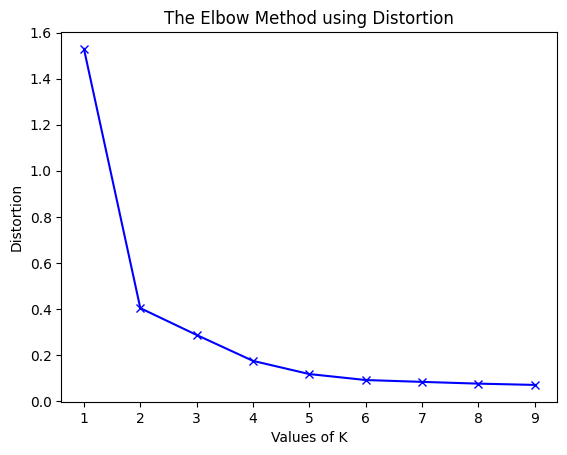

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Using the Elbow method with KMeans clustering, we can see that 2 clusters is the optimal number of clusters for our network. This seems reasonable considering there are 2 connected components in the network. Next, we will use Spectral Clustering to generate the clusters and labels

In [ ]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(2, affinity='precomputed', n_init=100)
sc.fit(A)

print(sc.labels_) # Spectral Clustering Labels

[1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1
 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0]


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
# Plotting the network using networkx

G_cluster = nx.MultiDiGraph()
G_cluster.add_nodes_from(range(0, 54))

for i in range(rows):
  for j in range(rows):
    if A_weights[i][j] != 0:
      G_cluster.add_edge(i, j, weight=A_weights[i][j])

# Assigning edge colors - allows us to visualize the traveling trends
edge_colors = ['green' if edge[2]['weight'] <= average else 'red' for edge in G_cluster.edges(data=True)]
G_cluster = nx.relabel_nodes(G_cluster, int2label)

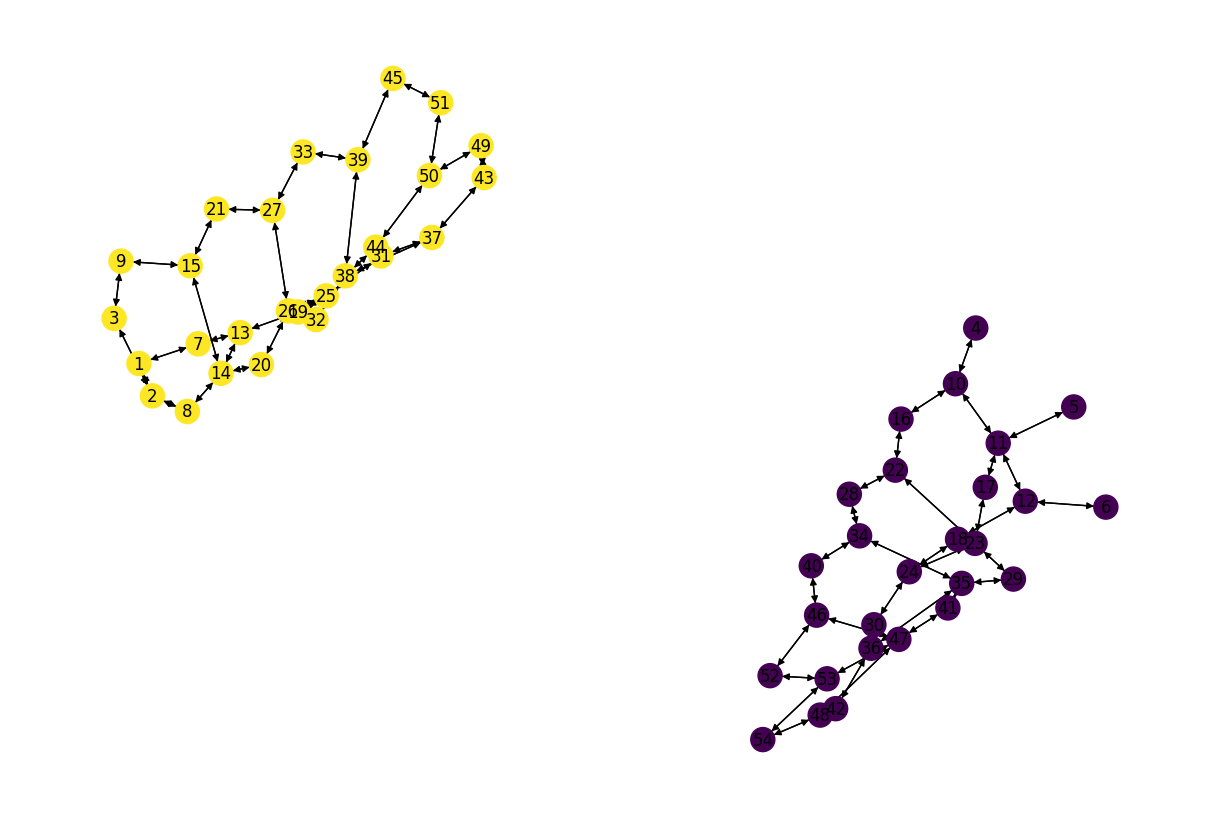

In [ ]:
pos = nx.spring_layout(G_cluster, scale=7) # Seed for replicability
plt.figure(3,figsize=(12,8))
nx.draw(G_cluster, pos, node_color=sc.labels_, with_labels=True)
plt.show()

The plotted graph with cluster labels represented by colors support this - each connected component is classified as one cluster. Intuitively, this is what we would expect.

## Feature Engineering before clustering within each connected component

We next look at a more local view, i.e. clusters within each connected component. Our aim is to identify different clusters within each connected component of the MRT network

In [ ]:
import copy as cp

In [ ]:
# Creating DataFrame to store the adjacency matrix -> if we use numpy array its harder to store the labels of the nodes if we are filtering out some node labels
# E.g. taking out node 1 from the array, the adj matrix will interpret node 2 as the "new" node 1, then the labels will be off
df_adj = pd.DataFrame(A, columns=list(range(1, 55)), index=list(range(1,55)))
df_weights = pd.DataFrame(A_weights, columns=list(range(1, 55)), index=list(range(1,55)))

A_1 = cp.deepcopy(df_adj)
A_2 = cp.deepcopy(df_adj)

A_1.drop(components[1], axis=1, inplace=True)
A_1.drop(components[1], inplace=True)

A_2.drop(components[0], axis=1, inplace=True)
A_2.drop(components[0], inplace=True)

A_1 = pd.DataFrame.to_numpy(A_1)
A_2 = pd.DataFrame.to_numpy(A_2)

## Component 1

In [ ]:
G_1 = G.subgraph(list(components[0]))

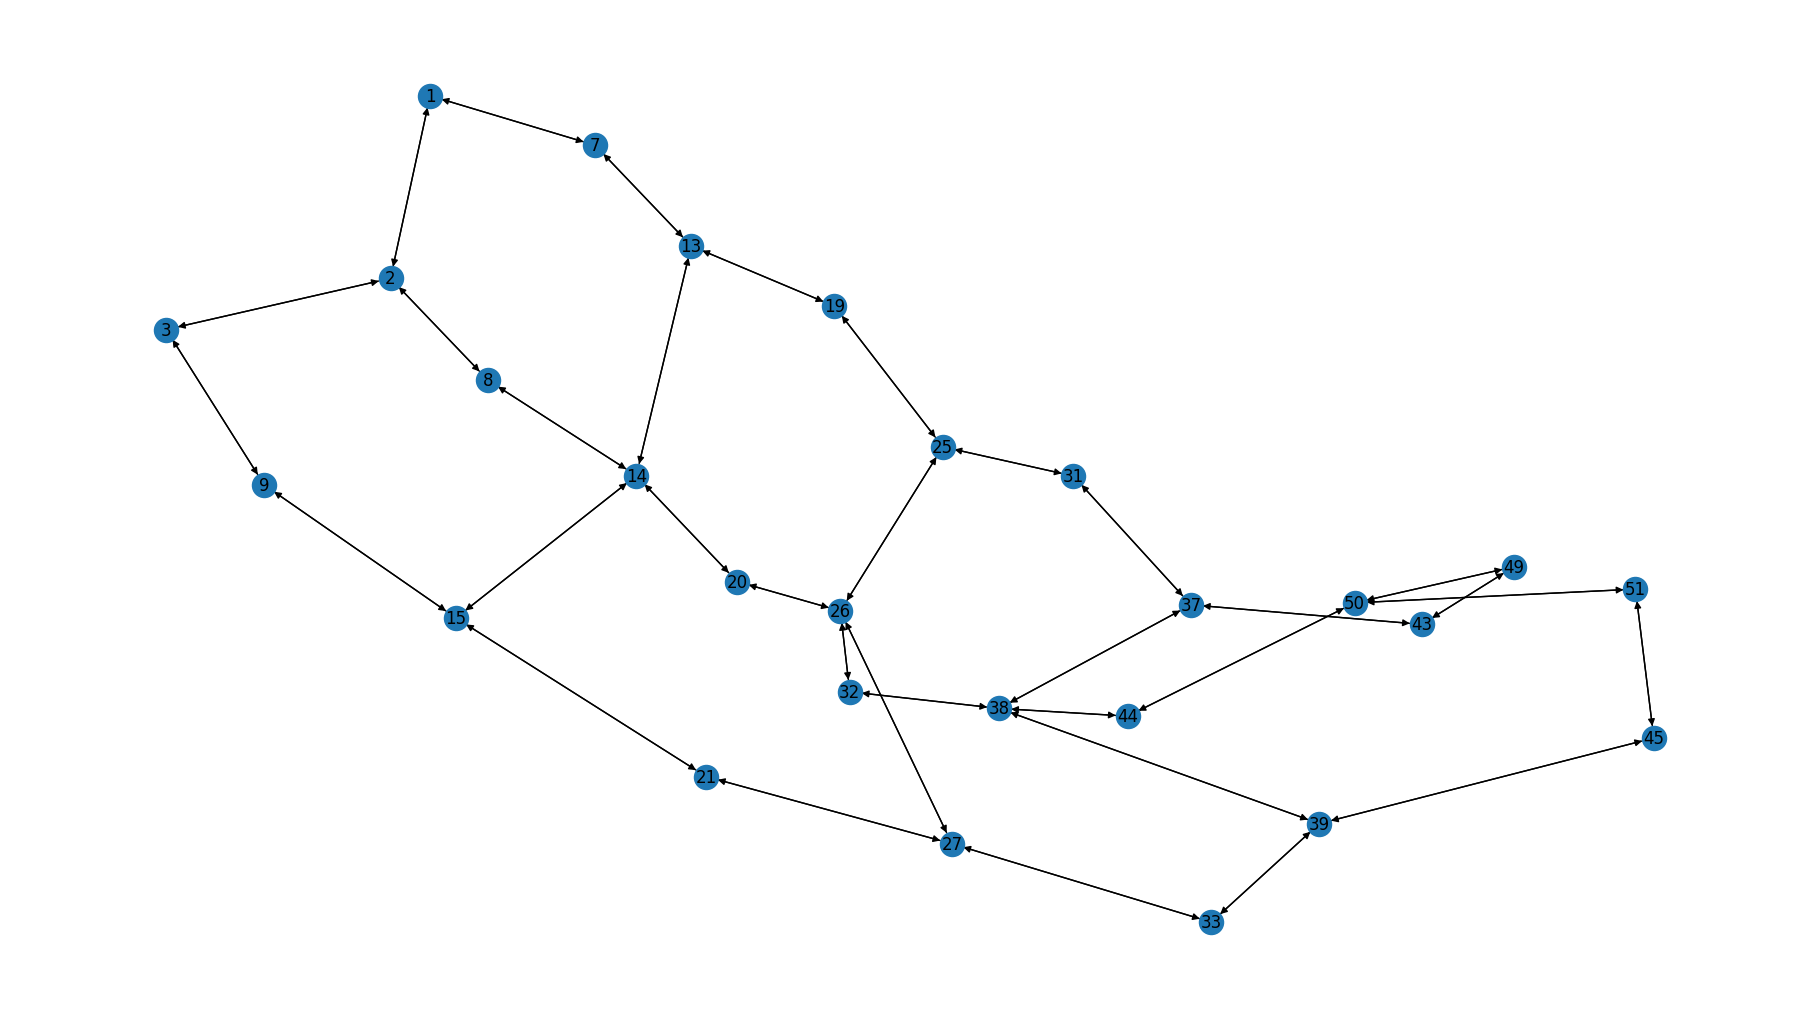

In [ ]:
pos = nx.spring_layout(G_1, scale=8) # Seed for replicability
plt.figure(3,figsize=(18,10))
nx.draw(G_1, pos, with_labels=True)
plt.show()

In [ ]:
# Generate walks
node2vec = Node2Vec(G_1, dimensions=2, workers=1, num_walks=30)
# Learn embeddings
model = node2vec.fit(window=10, min_count=1)
model.wv.save_word2vec_format("embedding_1.emb")

X_1 = np.loadtxt("embedding_1.emb", skiprows=1) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X_1=X_1[X_1[:,0].argsort()]
#print(X)
Z_1=X_1[0:X_1.shape[0],1:X_1.shape[1]]

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
  # Building and fitting the model
  kmeanModel = KMeans(n_clusters=k).fit(Z_1)
  kmeanModel.fit(Z_1)

  distortions.append(sum(np.min(cdist(Z_1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Z_1.shape[0])
  inertias.append(kmeanModel.inertia_)

  mapping1[k] = sum(np.min(cdist(Z_1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Z_1.shape[0]
  mapping2[k] = kmeanModel.inertia_

Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 30/30 [00:00<00:00, 58.97it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.war

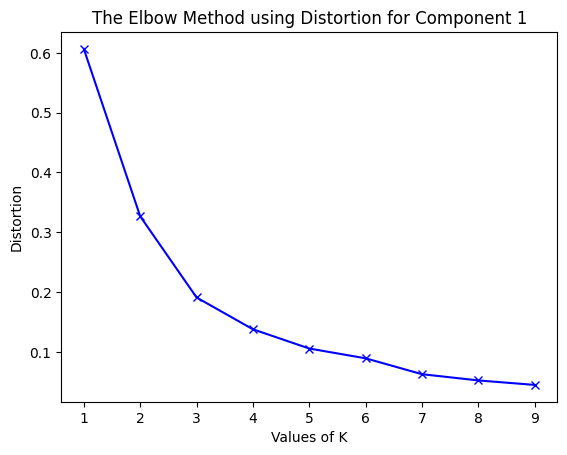

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion for Component 1')
plt.show()

Based on the Elbow graph, we determine the optimal number of clusters to be about K=3 clusters

In [ ]:
sc = SpectralClustering(3, affinity='precomputed', n_init=100)
sc.fit(A_1)

print(sc.labels_) # Spectral Clustering Labels

[1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]


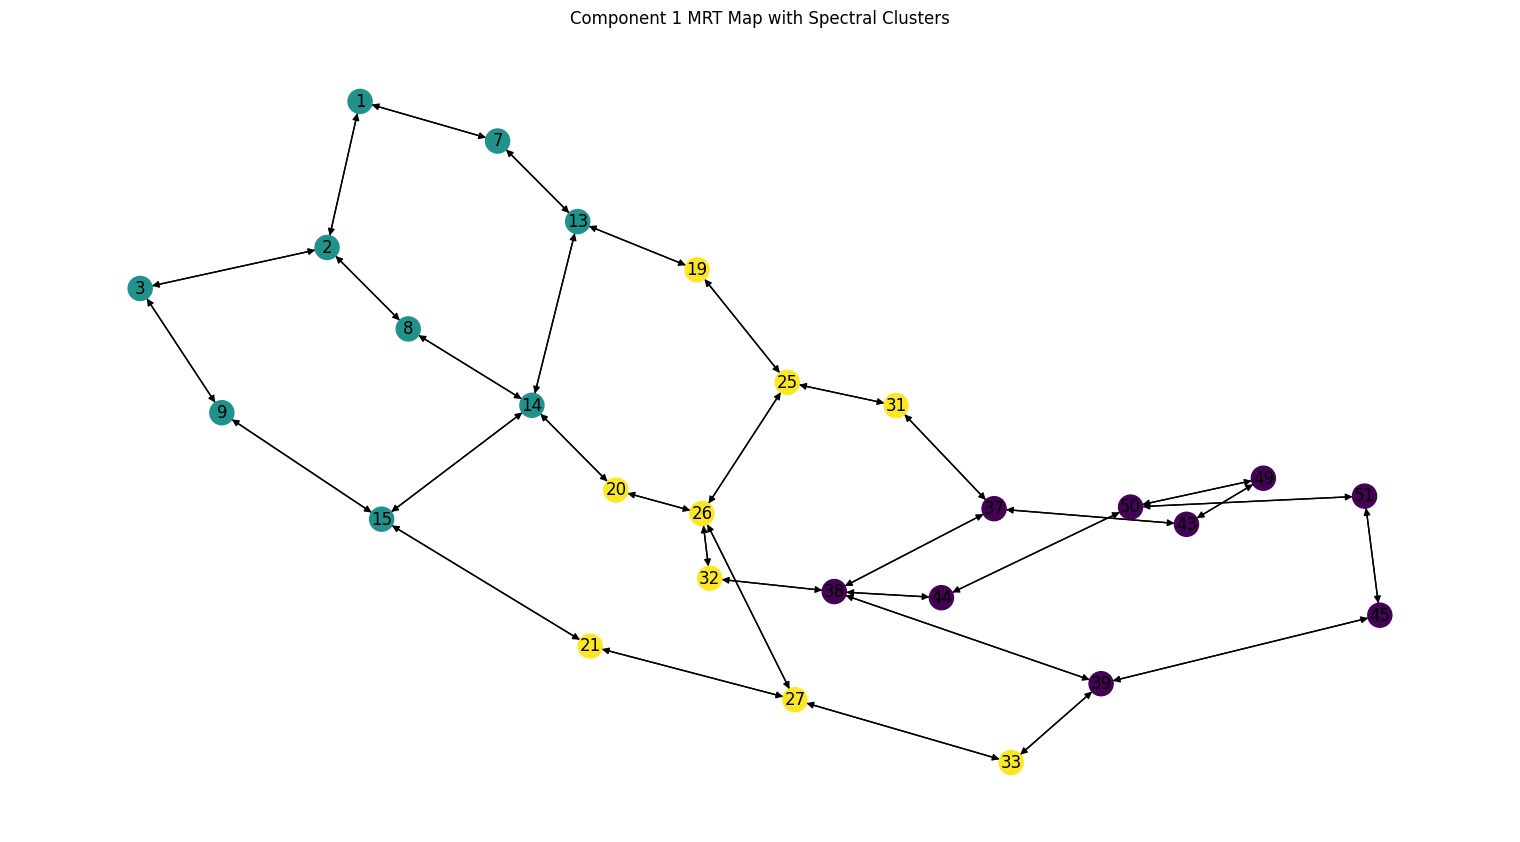

In [ ]:
plt.figure(3,figsize=(15,8))
nx.draw(G_1, pos, node_color=sc.labels_, with_labels=True)
plt.title("Component 1 MRT Map with Spectral Clusters")
plt.show()

In [ ]:
nodes = list(G_1.nodes())
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(len(nodes)):
  node = nodes[i]
  label = sc.labels_[i]
  if label == 0:
    cluster_1.append(node)
  elif label == 1:
    cluster_2.append(node)
  else:
    cluster_3.append(node)

In [ ]:
G_cluster_1 = G_1.subgraph(cluster_1)
G_cluster_2 = G_1.subgraph(cluster_2)
G_cluster_3 = G_1.subgraph(cluster_3)

In [ ]:
closeness_1 = nx.closeness_centrality(G_cluster_1) # Get the closeness centrality scores for every node in the cluster
node_1 = max(closeness_1, key=closeness_1.get) # Extract the station with the highest closeness centrality

closeness_2 = nx.closeness_centrality(G_cluster_2)
node_2 = max(closeness_2, key=closeness_2.get)

closeness_3 = nx.closeness_centrality(G_cluster_3)
node_3 = max(closeness_3, key=closeness_3.get)

In [ ]:
print(f'For Component 1, we will be linking {node_1}, {node_2}, and {node_3} together')

For Component 1, we will be linking 38, 2, and 26 together


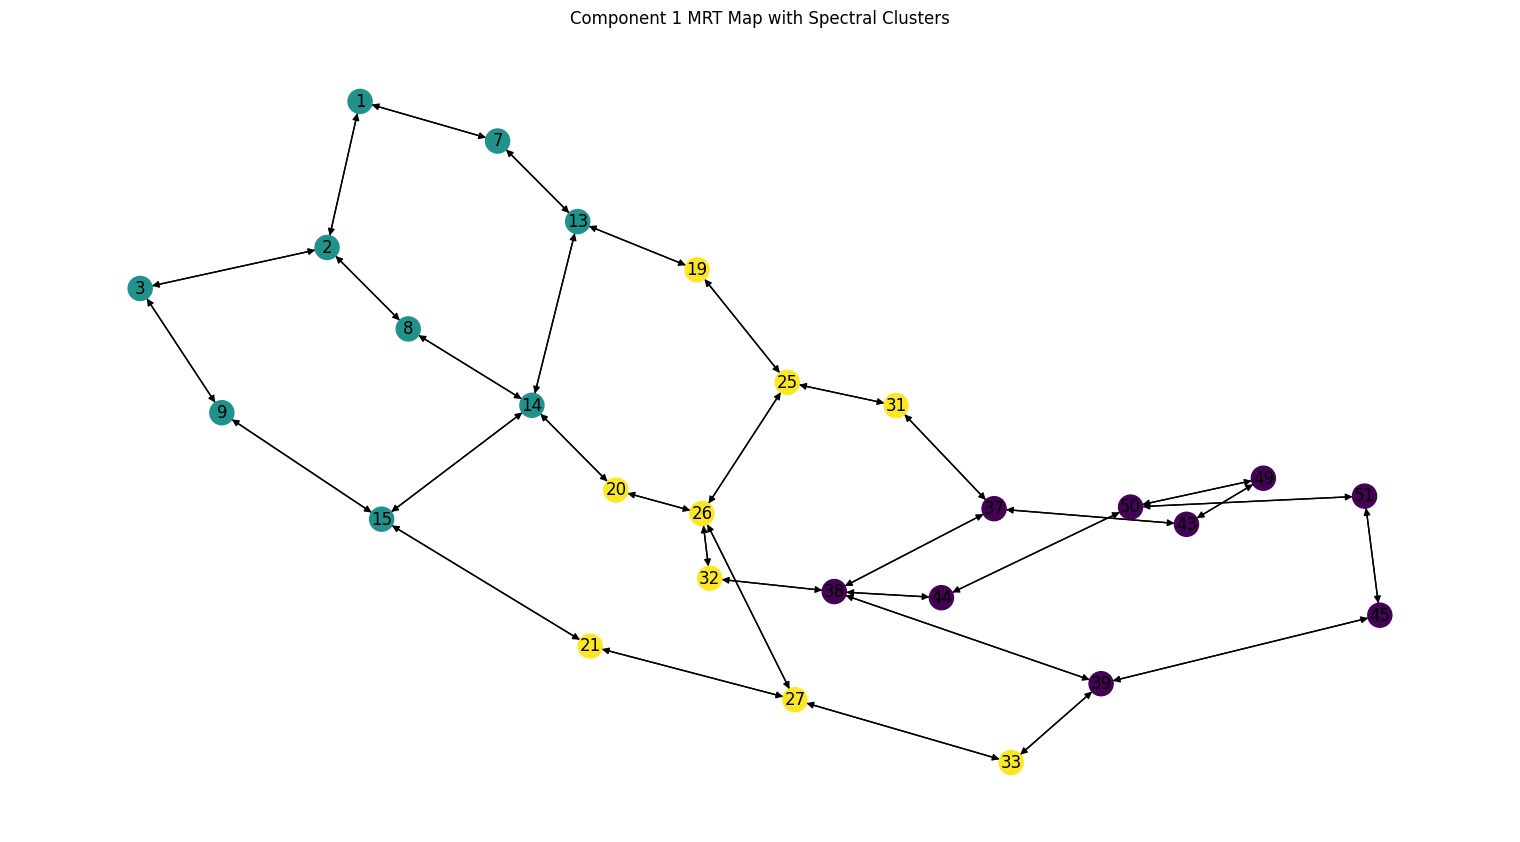

In [ ]:
plt.figure(3,figsize=(15,8))
nx.draw(G_1, pos, node_color=sc.labels_, with_labels=True)
plt.title("Component 1 MRT Map with Spectral Clusters")
plt.show()

Thanks to the visual representation of the network, we can make some intuitive decisions on how to link the clusters, i.e. we do not want to make a link from cluster 1 to cluster 3 if cluster 2 is graphically between 1 and 3.

In [ ]:
copy = nx.MultiDiGraph(G_1)

In [ ]:
copy.add_edge(2, 26)
copy.add_edge(26, 38)
copy.add_edge(38, 2)

0

In [ ]:
added_edges = [(2, 26), (26, 38), (38, 2)]

In [ ]:
edge_colors = ['red' if edge in added_edges else 'black' for edge in copy.edges()]

We plot the new graph representation of Component 2 below, with the newly added edges highlighted in red. We can see how the network becomes more connected, with each cluster being linked to one another with more direct links that connect the nodes with the highest closeness centrality to one another.

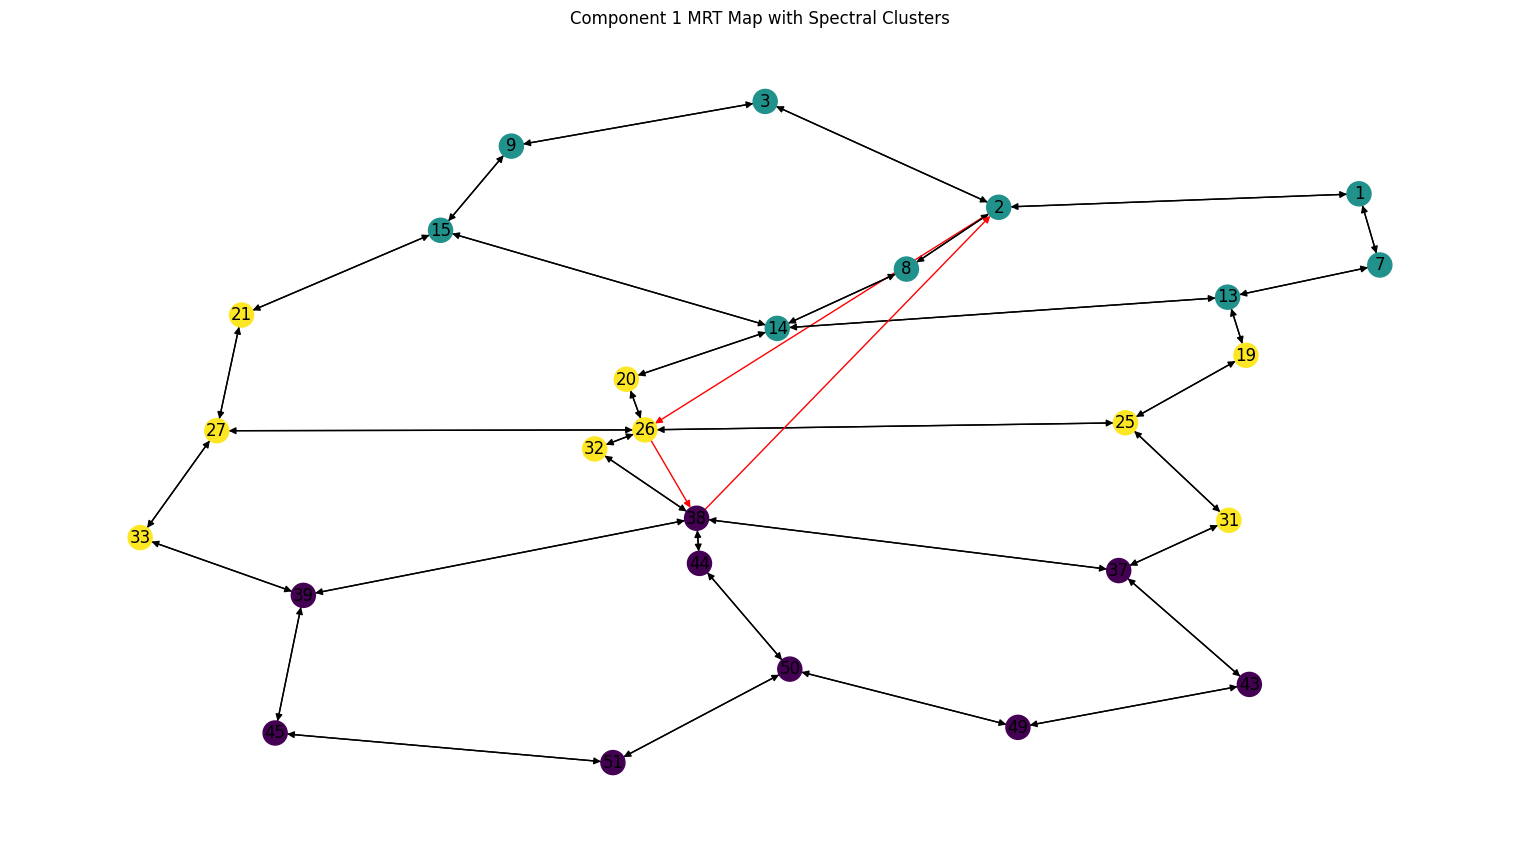

In [ ]:
pos = nx.spring_layout(copy, scale=8) # Seed for replicability
plt.figure(3,figsize=(15,8))
nx.draw(copy, pos, node_color=sc.labels_, edge_color=edge_colors, with_labels=True)
plt.title("Component 1 MRT Map with Spectral Clusters")
plt.show()

## Component 2

In [ ]:
G_2 = G.subgraph(list(components[1]))

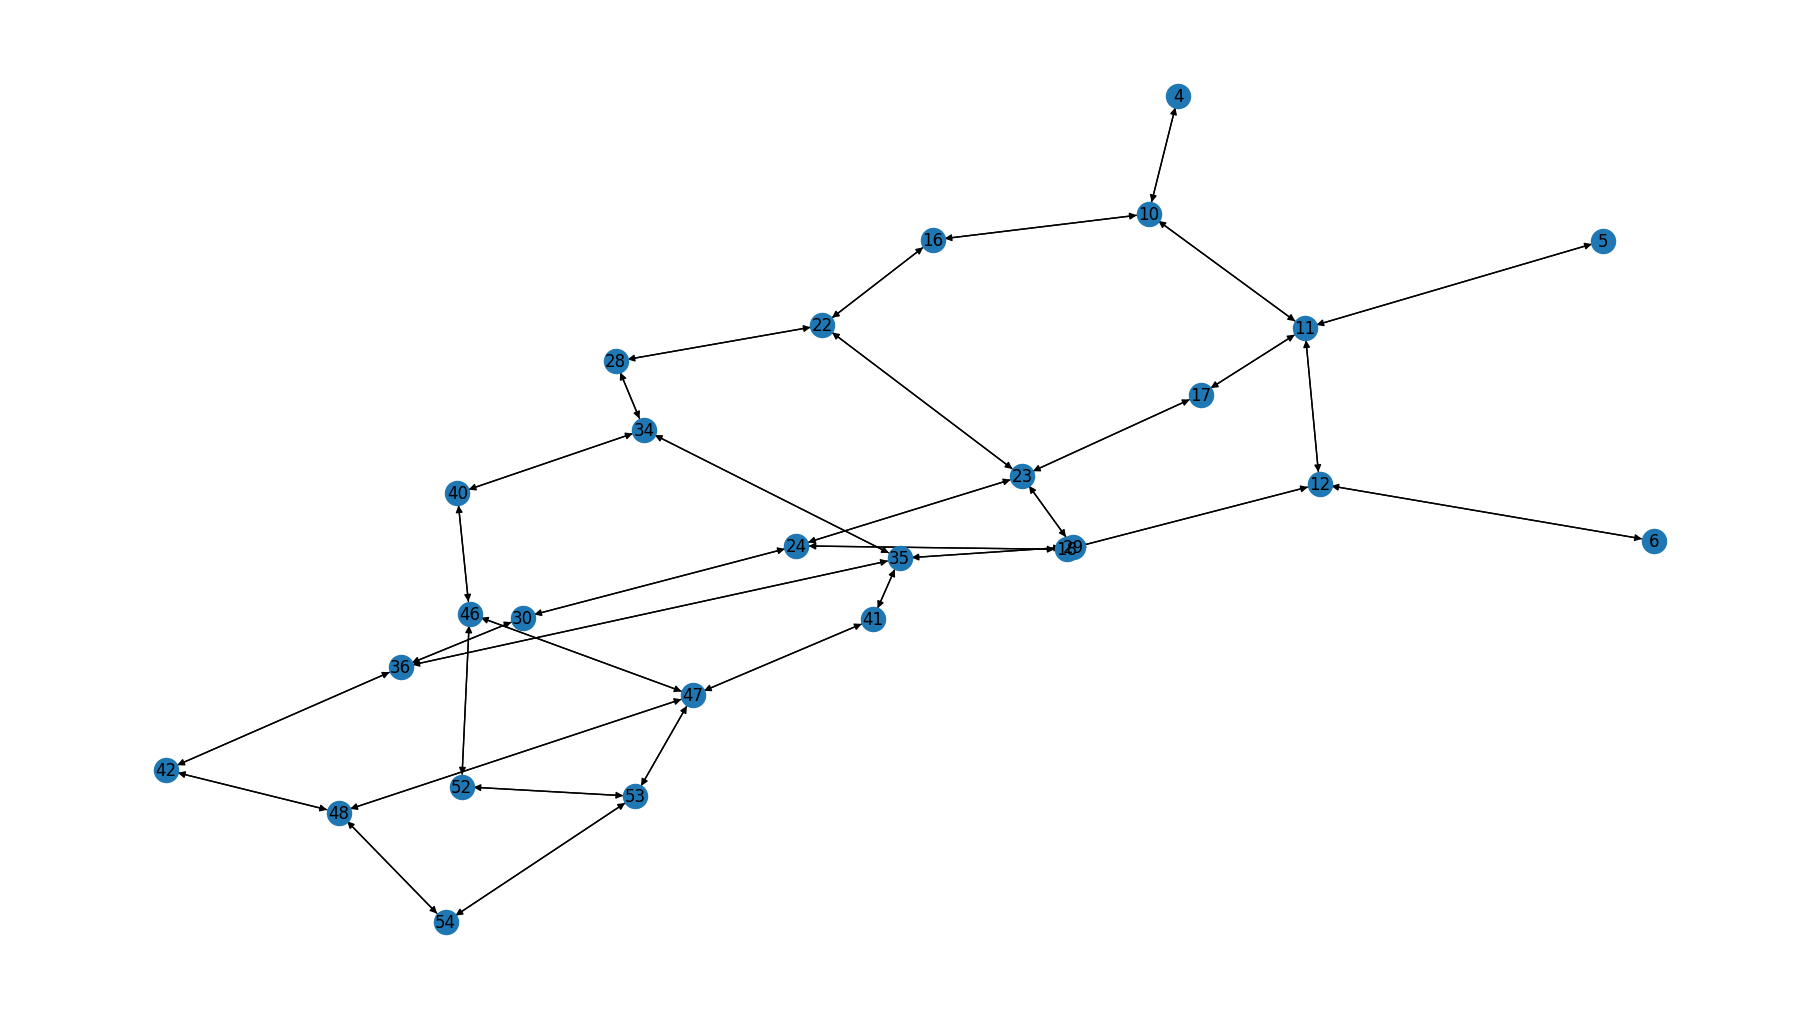

In [ ]:
pos = nx.spring_layout(G_2, scale=8) # Seed for replicability
plt.figure(3,figsize=(18,10))
nx.draw(G_2, pos, with_labels=True)
plt.show()

In [ ]:
# Generate walks
node2vec = Node2Vec(G_2, dimensions=2, workers=1, num_walks=30)
# Learn embeddings
model = node2vec.fit(window=10, min_count=1)
model.wv.save_word2vec_format("embedding_2.emb")

X_2 = np.loadtxt("embedding_2.emb", skiprows=1) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X_2=X_2[X_2[:,0].argsort()]
#print(X)
Z_2=X_2[0:X_2.shape[0],1:X_2.shape[1]]

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
  # Building and fitting the model
  kmeanModel = KMeans(n_clusters=k).fit(Z_2)
  kmeanModel.fit(Z_2)

  distortions.append(sum(np.min(cdist(Z_2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Z_2.shape[0])
  inertias.append(kmeanModel.inertia_)

  mapping1[k] = sum(np.min(cdist(Z_2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Z_2.shape[0]
  mapping2[k] = kmeanModel.inertia_

Computing transition probabilities:   0%|          | 0/27 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 30/30 [00:00<00:00, 86.98it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.war

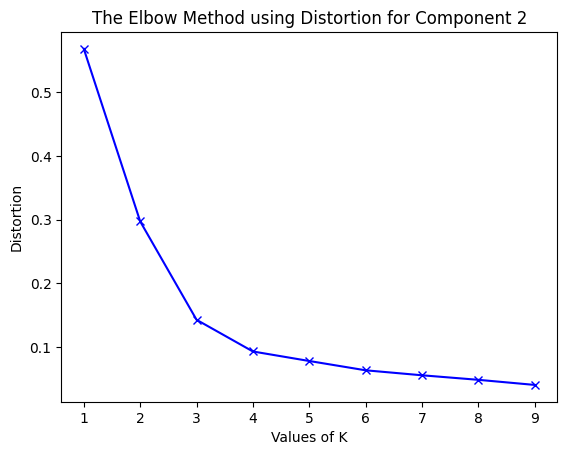

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion for Component 2')
plt.show()

Based on the Elbow graph, we determine the optimal number of clusters to be about K=4 clusters

In [ ]:
sc = SpectralClustering(4, affinity='precomputed', n_init=100)
sc.fit(A_2)

print(sc.labels_) # Spectral Clustering Labels

[3 3 1 3 3 1 3 3 1 0 0 1 0 0 1 0 0 0 0 0 2 2 2 2 2 2 2]


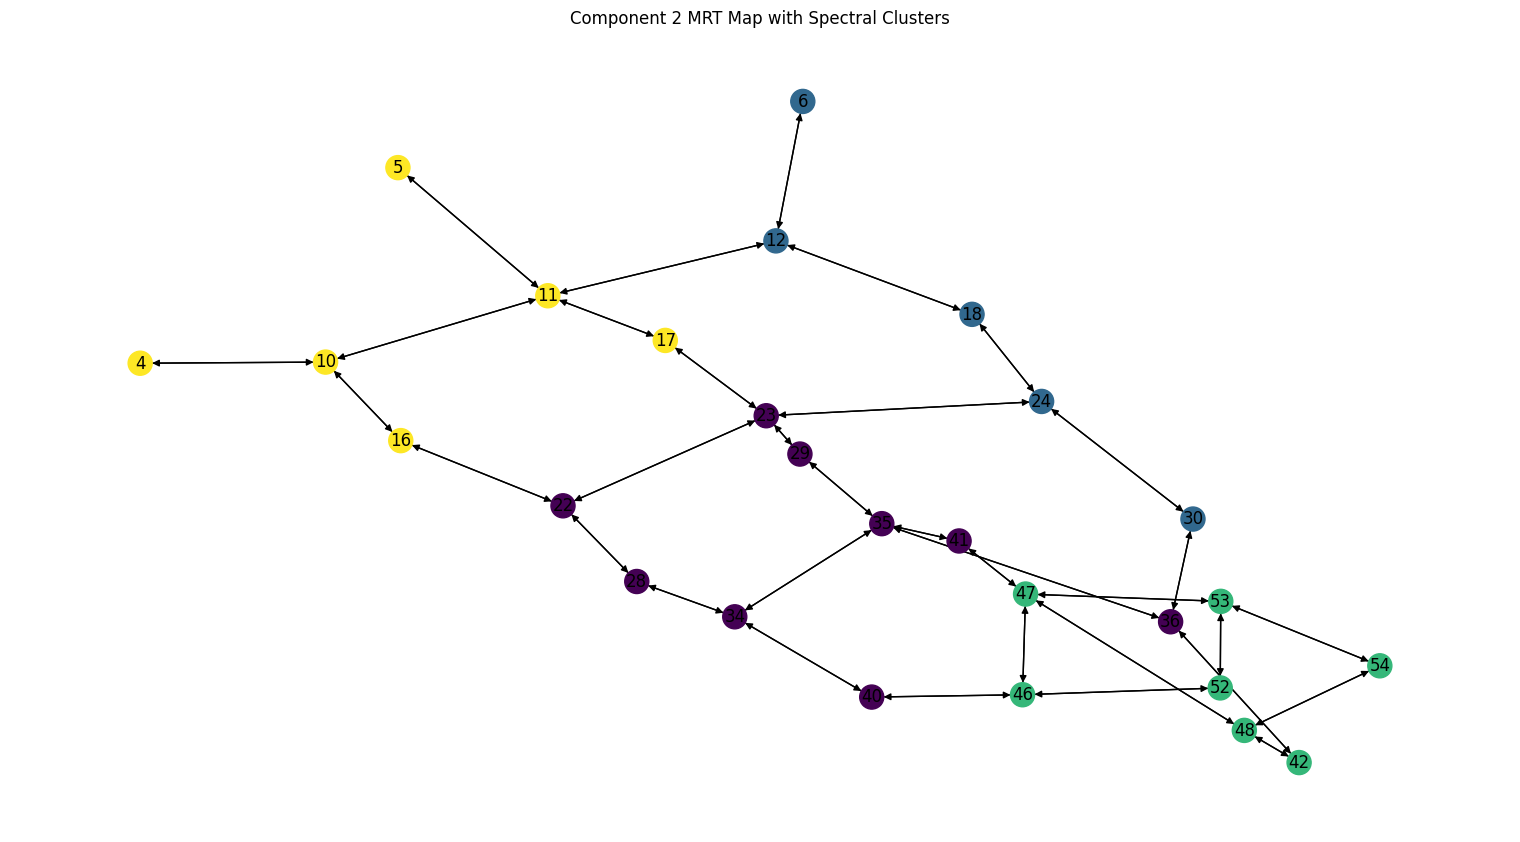

In [ ]:
pos = nx.spring_layout(G_2, scale=8) # Seed for replicability
plt.figure(3,figsize=(15,8))
nx.draw(G_2, pos, node_color=sc.labels_, with_labels=True)
plt.title("Component 2 MRT Map with Spectral Clusters")
plt.show()

In [ ]:
nodes = list(G_2.nodes())
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []

for i in range(len(nodes)):
  node = nodes[i]
  label = sc.labels_[i]
  if label == 0:
    cluster_1.append(node)
  elif label == 1:
    cluster_2.append(node)
  elif label == 2:
    cluster_3.append(node)
  else:
    cluster_4.append(node)

In [ ]:
G_cluster_1 = G_2.subgraph(cluster_1)
G_cluster_2 = G_2.subgraph(cluster_2)
G_cluster_3 = G_2.subgraph(cluster_3)
G_cluster_4 = G_2.subgraph(cluster_4)

In [ ]:
closeness_1 = nx.closeness_centrality(G_cluster_1) # Get the closeness centrality scores for every node in the cluster
node_1 = max(closeness_1, key=closeness_1.get) # Extract the station with the highest closeness centrality

closeness_2 = nx.closeness_centrality(G_cluster_2)
node_2 = max(closeness_2, key=closeness_2.get)

closeness_3 = nx.closeness_centrality(G_cluster_3)
node_3 = max(closeness_3, key=closeness_3.get)

closeness_4 = nx.closeness_centrality(G_cluster_4)
node_4 = max(closeness_4, key=closeness_4.get)

In [ ]:
print(f'For Component 2, we will be linking {node_1}, {node_2}, {node_3}, and {node_4} together')

For Component 2, we will be linking 35, 18, 47, and 10 together


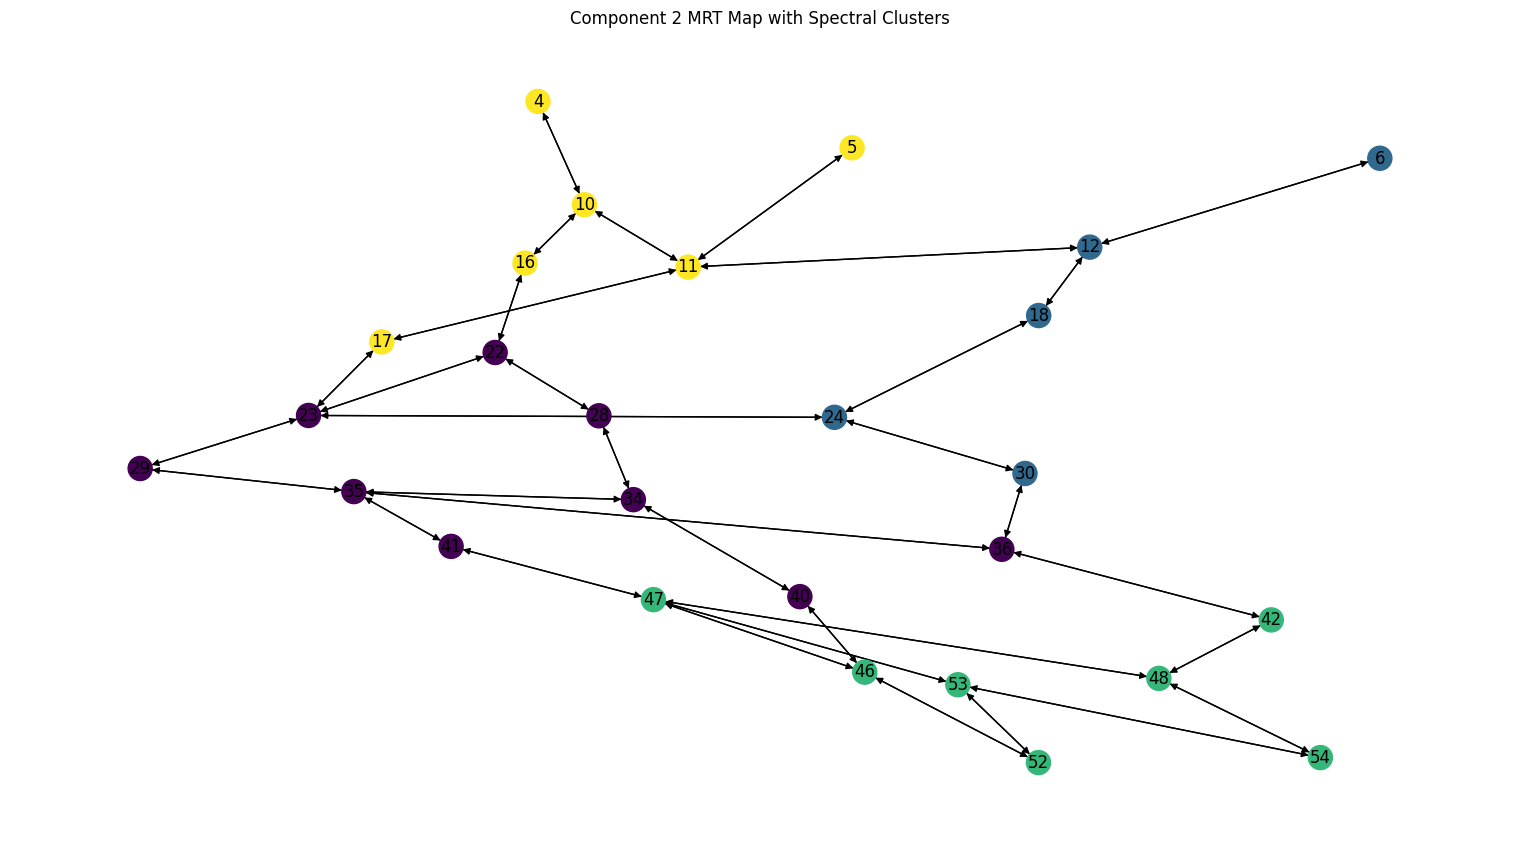

In [ ]:
pos = nx.spring_layout(G_2, scale=8) # Seed for replicability
plt.figure(3,figsize=(15,8))
nx.draw(G_2, pos, node_color=sc.labels_, with_labels=True)
plt.title("Component 2 MRT Map with Spectral Clusters")
plt.show()

Thanks to the visual representation of the network, we can make some intuitive decisions on how to link the clusters, i.e. we do not want to make a link from cluster 1 to cluster 3 if cluster 2 is graphically between 1 and 3.


In [ ]:
copy = nx.MultiDiGraph(G_2)

In [ ]:
copy.add_edge(11, 16)
copy.add_edge(11, 35)
copy.add_edge(35, 47)
copy.add_edge(16, 47)

0

In [ ]:
added_edges = [(11, 16), (11, 35), (35, 47), (16, 47)]

In [ ]:
edge_colors = ['red' if edge in added_edges else 'black' for edge in copy.edges()]

We plot the new graph representation of Component 2 below, with the newly added edges highlighted in red. We can see how the network becomes more connected, with each cluster being linked to one another with more direct links that connect the nodes with the highest closeness centrality to one another.

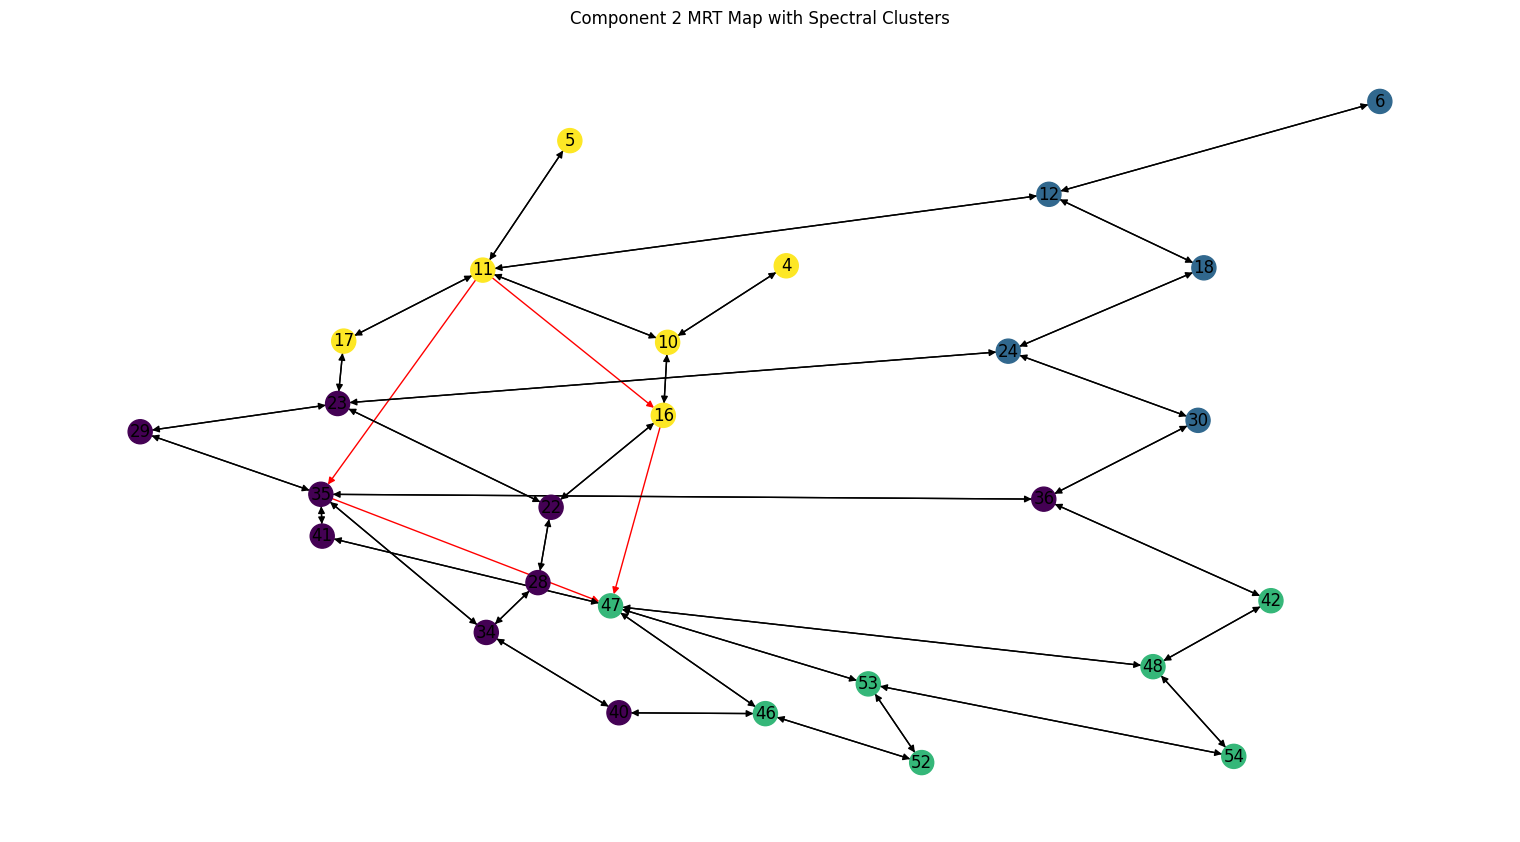

In [ ]:
pos = nx.spring_layout(copy, scale=8) # Seed for replicability
plt.figure(3,figsize=(15,8))
nx.draw(copy, pos, node_color=sc.labels_, edge_color=edge_colors, with_labels=True)
plt.title("Component 2 MRT Map with Spectral Clusters")
plt.show()

# **Objective 3.1**

Add on to objective 3. Instead of joining stations with high closeness centrality, another option can be to join them to any adjacent stations that isn't an interchange yet or create a new station that joins these stations together

In [ ]:
nodes = list(G_1.nodes())
cluster_1 = []
cluster_2 = []
cluster_3 = []

for i in range(len(nodes)):
  node = nodes[i]
  label = sc.labels_[i]
  if label == 0:
    cluster_1.append(node)
  elif label == 1:
    cluster_2.append(node)
  else:
    cluster_3.append(node)

G_cluster_1 = G_1.subgraph(cluster_1)
G_cluster_2 = G_1.subgraph(cluster_2)
G_cluster_3 = G_1.subgraph(cluster_3)

# tried betweenness centrality --> same as closeness
closeness_1 = nx.betweenness_centrality(G_cluster_1) # Get the closeness centrality scores for every node in the cluster
node_1 = max(closeness_1, key=closeness_1.get) # Extract the station with the highest closeness centrality

closeness_2 = nx.betweenness_centrality(G_cluster_2)
node_2 = max(closeness_2, key=closeness_2.get)

closeness_3 = nx.betweenness_centrality(G_cluster_3)
node_3 = max(closeness_3, key=closeness_3.get)

print(f'For Component 1, we will be linking {node_1}, {node_2}, and {node_3} together')

For Component 1, we will be linking 25, 15, and 50 together


In [ ]:
sc = SpectralClustering(3, affinity='precomputed', n_init=100)
sc.fit(A_1)

print(sc.labels_) # Spectral Clustering Labels

[1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]


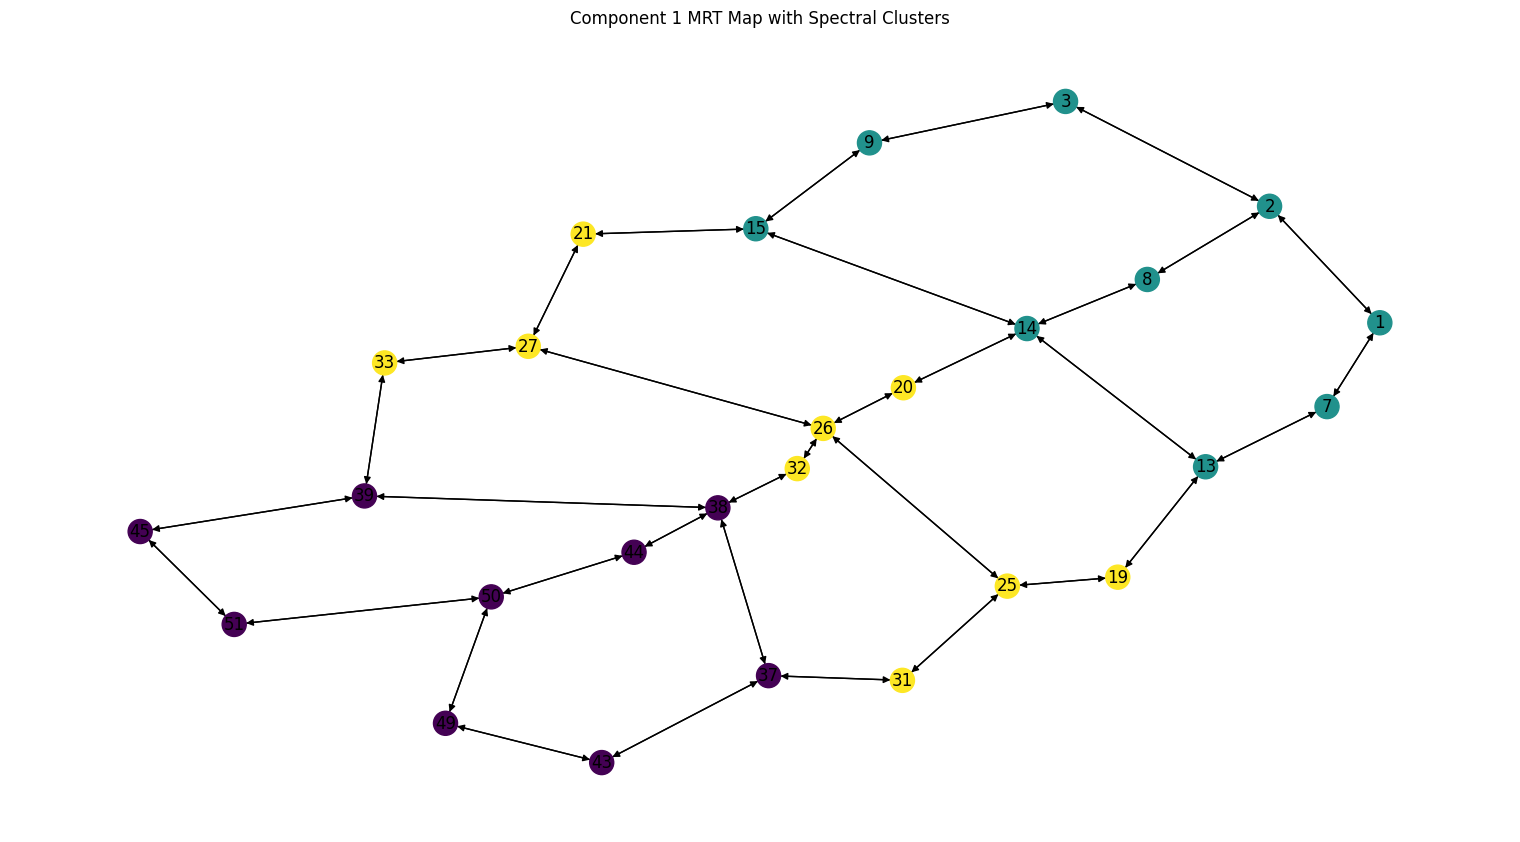

In [ ]:
pos = nx.spring_layout(G_1, scale=8) # Seed for replicability
plt.figure(3,figsize=(15,8))
nx.draw(G_1, pos, node_color=sc.labels_, with_labels=True)
plt.title("Component 1 MRT Map with Spectral Clusters")
plt.show()

In this objective, we explore the possibility of creating a new interchange to join the clusters together.

**Component 1**

In [ ]:
new_interchange = nx.MultiDiGraph(G_1)
new_interchange.add_node("I")
new_interchange.add_edge(2, "I")
new_interchange.add_edge(26, "I")
new_interchange.add_edge(38, "I")
new_interchange.add_edge("I",2)
new_interchange.add_edge("I",26)
new_interchange.add_edge("I",38)

0

In [ ]:
col = np.append(sc.labels_, [4])
col

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4])

In [ ]:
added_edges = [(2, "I"), (26, "I"), (38, "I"), ("I",2), ("I",26), ("I",38)]
edge_colors = ['red' if edge in added_edges else 'black' for edge in new_interchange.edges()]

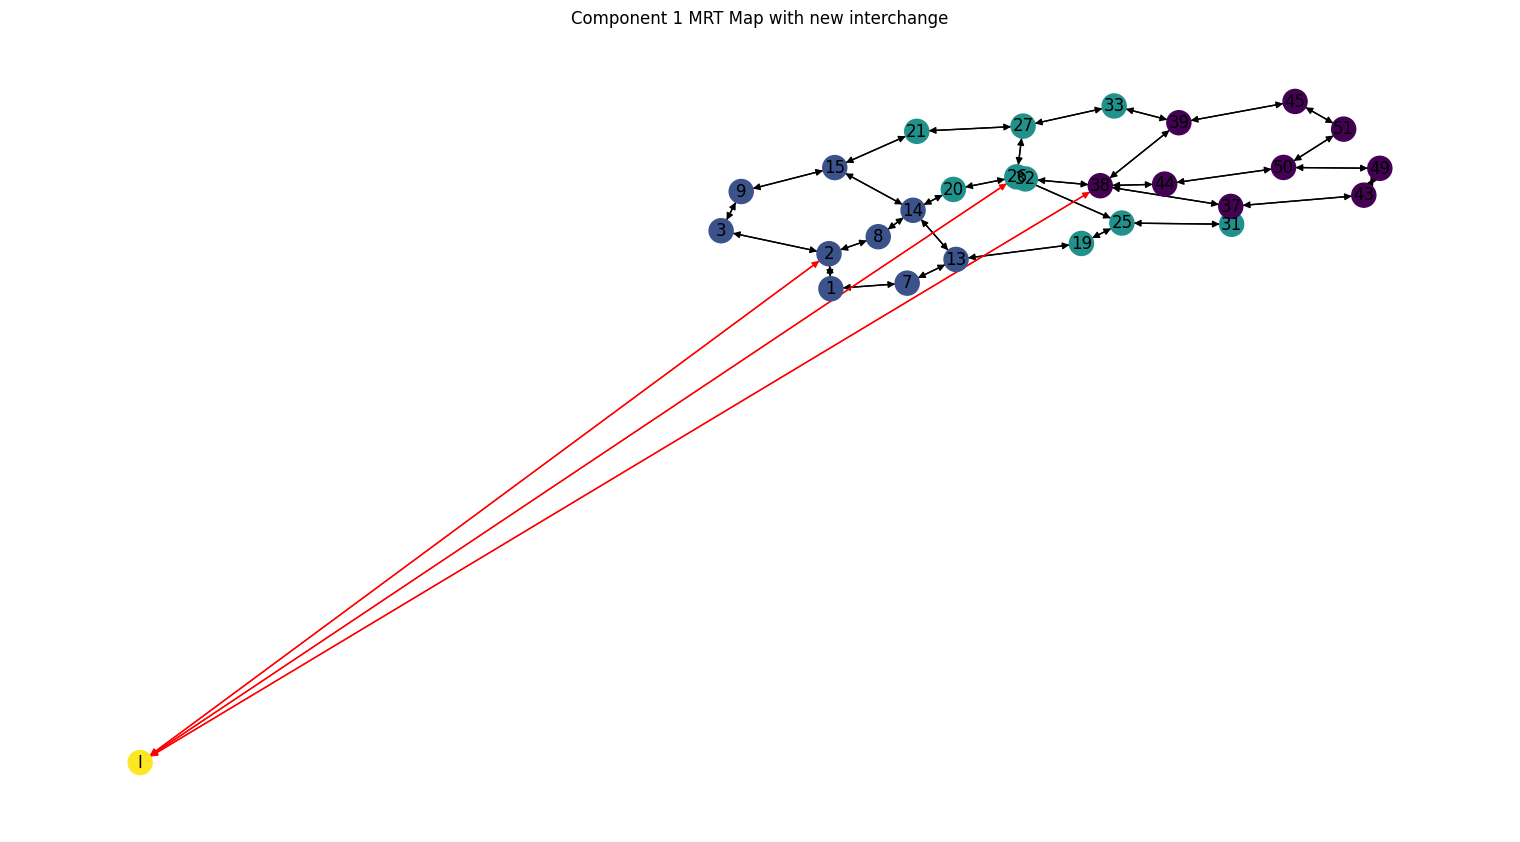

In [ ]:
pos = nx.spring_layout(new_interchange, scale=10) # Seed for replicability
plt.figure(3,figsize=(15,8))
nx.draw(new_interchange, pos, edge_color=edge_colors, with_labels=True, node_color=col)
plt.title("Component 1 MRT Map with new interchange")
plt.show()

**Component 2**

In [ ]:
new_interchange_c2 = nx.MultiDiGraph(G_2)
new_interchange_c2.add_node("I")
new_interchange_c2.add_edge(10, "I", length = 1)
new_interchange_c2.add_edge(47, "I", length = 1)
new_interchange_c2.add_edge(34, "I", length = 1)
new_interchange_c2.add_edge(18, "I", length = 1)
new_interchange_c2.add_edge("I",10, length = 1)
new_interchange_c2.add_edge("I",47, length = 1)
new_interchange_c2.add_edge("I",34, length = 1)
new_interchange_c2.add_edge("I",18, length = 1)

0

In [ ]:
sc = SpectralClustering(4, affinity='precomputed', n_init=100)
sc.fit(A_2)

print(sc.labels_) # Spectral Clustering Labels

col = np.append(sc.labels_, [4])
col

[3 1 1 3 1 1 3 1 1 3 0 0 3 0 0 0 0 0 2 0 0 2 2 2 2 2 2]


array([3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 4])

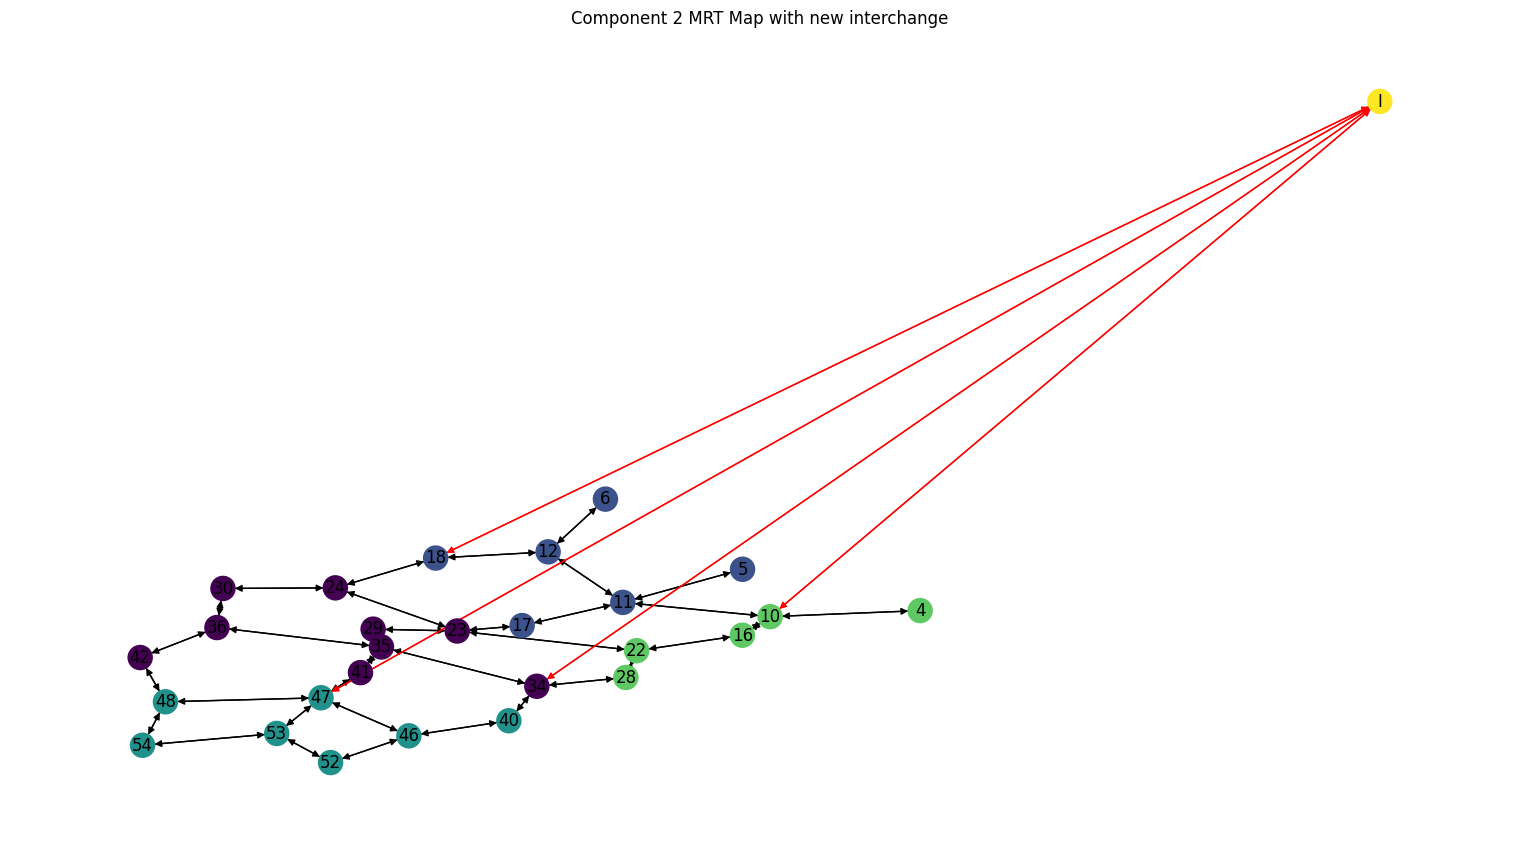

In [ ]:
added_edges = [(10, "I"), (47, "I"), (34, "I"), (18, "I"), ("I",10), ("I",47), ("I",34), ("I", 18)]
edge_colors = ['red' if edge in added_edges else 'black' for edge in new_interchange_c2.edges()]

pos = nx.spring_layout(new_interchange_c2, scale=10) # Seed for replicability
plt.figure(3,figsize=(15,8))
nx.draw(new_interchange_c2, pos, edge_color=edge_colors, with_labels=True, node_color=col)
plt.title("Component 2 MRT Map with new interchange")
plt.show()

# **Objective 4**



Obtaining the shortest path of every passenger based on start/end station
*   Find passengers that are not taking the shortest path -> recommend shortest path to these passengers to improve their travelling experience




In [ ]:
df_time.head(3)

,0602hr,0604hr,0606hr,0608hr,0610hr,0612hr,0614hr,0616hr,0618hr,0620hr,...,0628hr,0630hr,0632hr,0634hr,0636hr,0638hr,Stations,commuter,Gender,Occupation
1,37,31,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2.0,1,male,politician
2,46,40,34,35,41,47,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6.0,2,female,politician
3,36,30,24,18,12,6,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6.0,3,female,politician


In [ ]:
time = df_time.drop(columns=['Stations', 'commuter', 'Gender', 'Occupation'])
time.head(3)

,0602hr,0604hr,0606hr,0608hr,0610hr,0612hr,0614hr,0616hr,0618hr,0620hr,0622hr,0624hr,0626hr,0628hr,0630hr,0632hr,0634hr,0636hr,0638hr
1,37,31,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,46,40,34,35,41,47,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,36,30,24,18,12,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
time['Shortest_Path'] = np.nan
for row in range(df_time.shape[0]):
  start = df_time.iloc[row, 0]
  for column in range(1, df_time.shape[1]):
    curr_station = df_time.iloc[row, column]
    if pd.isnull(curr_station):
      end = df_time.iloc[row, column - 1]
      shortest_path = len(nx.shortest_path(G, source=start, target=end))
      time['Shortest_Path'].iat[row] = shortest_path
      break

In [ ]:
df_time = pd.concat([df_time, time[['Shortest_Path']]], axis=1)

In [ ]:
non_optimal = df_time[df_time['Shortest_Path'] < df_time['Stations']]

In [ ]:
non_optimal

,0602hr,0604hr,0606hr,0608hr,0610hr,0612hr,0614hr,0616hr,0618hr,0620hr,...,0630hr,0632hr,0634hr,0636hr,0638hr,Stations,commuter,Gender,Occupation,Shortest_Path
2,46,40,34,35,41,47,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,6.0,2,female,politician,2.0
5,43,49,50,44,38,32,26,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,7.0,5,male,worker,5.0
8,1,7,13,14,8,2,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,6.0,8,female,worker,2.0
9,4,10,16,22,28,34,40,46,52,53,...,<NA>,<NA>,<NA>,<NA>,<NA>,14.0,9,female,politician,6.0
12,11,17,23,29,35,41,47,53,54,48,...,<NA>,<NA>,<NA>,<NA>,<NA>,13.0,12,female,worker,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,1,7,13,19,25,31,37,43,49,50,...,<NA>,<NA>,<NA>,<NA>,<NA>,14.0,99991,female,student,6.0
99994,17,11,10,16,22,28,34,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,7.0,99994,male,politician,5.0
99997,16,22,28,34,35,29,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,6.0,99997,male,politician,4.0
99999,16,10,11,12,18,24,30,36,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,8.0,99999,male,worker,6.0


Based on the data, we see a considerable number of passengers that are not taking the shortest route from their starting destination to their ending station, specifically 44,323 passengers. This could be due to several reasons, such as taking a longer route to meet friends at work along the way, or to meet classmates along the way to school. However, based on the sheer number of passengers in the dataset that are not taking the most optimal route in terms of stations traversed, it would be safe to assume some passengers may not be aware of a shorter, more optimal path.

We can use our findings from the analysis in this objective to justify the suggestion of installing devices in MRT stations that passengers can use to find the shortest path to their destinations, reducing unnecessary travel time and improving the transport experience.

# **Objective 5 & 6**

EDA on the entire network/component wise




In [ ]:
df_time_obj5 = df_time.drop(columns={'Stations',	'commuter',	'Gender',	'Occupation',	'Shortest_Path'})

In [ ]:
df_time_obj5.head(3)

,0602hr,0604hr,0606hr,0608hr,0610hr,0612hr,0614hr,0616hr,0618hr,0620hr,0622hr,0624hr,0626hr,0628hr,0630hr,0632hr,0634hr,0636hr,0638hr
1,37,31,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,46,40,34,35,41,47,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,36,30,24,18,12,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
s = df_time_obj5.apply(pd.Series.value_counts).idxmax(axis=1)
df_peak_stns_freq = pd.DataFrame({'station':s.index, 'time':s.values})

First, we find out what time is each station the most crowded. Below is the station number and its corresponding time where is has the most crowd.

Assumption: When we mean crowd, we assume that it includes boarding, alighting or transiting through that station.

In [ ]:
#what time is each station the most crowded + value_count
print(df_time_obj5.apply(pd.Series.value_counts).idxmax(axis=1))

1     0602hr
2     0602hr
3     0602hr
4     0602hr
5     0602hr
6     0602hr
7     0604hr
8     0604hr
9     0604hr
10    0604hr
11    0604hr
12    0604hr
13    0606hr
14    0606hr
15    0606hr
16    0604hr
17    0606hr
18    0604hr
19    0608hr
20    0608hr
21    0608hr
22    0606hr
23    0608hr
24    0606hr
25    0606hr
26    0608hr
27    0606hr
28    0608hr
29    0610hr
30    0608hr
31    0604hr
32    0604hr
33    0604hr
34    0606hr
35    0606hr
36    0606hr
37    0602hr
38    0616hr
39    0602hr
40    0604hr
41    0614hr
42    0604hr
43    0602hr
44    0622hr
45    0602hr
46    0602hr
47    0616hr
48    0602hr
49    0618hr
50    0620hr
51    0618hr
52    0612hr
53    0618hr
54    0616hr
dtype: object


Next, we will get the value count to further understand the most frequently occured time where there are most stations with peak crowd.

For instance, at 0604, there are 13 stations which has peak crowdedness.

In [ ]:
#what time is each station the most crowded + value_count
print(df_time_obj5.apply(pd.Series.value_counts).idxmax(axis=1).value_counts())

0604hr    13
0602hr    12
0606hr    11
0608hr     7
0616hr     3
0618hr     3
0610hr     1
0614hr     1
0622hr     1
0620hr     1
0612hr     1
dtype: int64


In [ ]:
for i in df_time_obj5.columns.tolist():
  stations = df_peak_stns_freq[df_peak_stns_freq['time']==i].station.tolist()
  print(f'{i}: {stations}')

0602hr: [1, 2, 3, 4, 5, 6, 37, 39, 43, 45, 46, 48]
0604hr: [7, 8, 9, 10, 11, 12, 16, 18, 31, 32, 33, 40, 42]
0606hr: [13, 14, 15, 17, 22, 24, 25, 27, 34, 35, 36]
0608hr: [19, 20, 21, 23, 26, 28, 30]
0610hr: [29]
0612hr: [52]
0614hr: [41]
0616hr: [38, 47, 54]
0618hr: [49, 51, 53]
0620hr: [50]
0622hr: [44]
0624hr: []
0626hr: []
0628hr: []
0630hr: []
0632hr: []
0634hr: []
0636hr: []
0638hr: []


With all the above mentioned information, we know what stations at each time interval are the busiest and suggestions that can improve commuter's experience.

Suggestions:

1.   Scehdule more trains/increase frequency during 0602-0608, since the bulk of the footfall are between these timings. This will
2.   Allocate staff and resources to manage the crowds more effectively during those specific timing that were mentioned for instance 0602-0604 since there are 12 and 13 stations with peak crowdedness respectively.
3. Implement higher security measures during the peak periods.
4. From 0624 onwards, the crowd gets lesser, hence the staff can allocate their timings properly.





------------------------------------------

Next, we find out the footfall at each time period and the culmulative footfall over a range of time. This can be done over the whole network (aka both components or separately to see whether it has different traffic patterns).


The function below takes in parameters:
1. dataframe used
2. starting time e.g. 602
3. ending time
4. n_largest is the number of printed values by the order
5. reverse aka ascending or descending order (to view the most/least crowded stations)
6. occupation (filter the data by the specified occupation)

and returns the culmulative foot-fall over the specified range of time.

In [ ]:
# freq_populated_stations --> [freq of usage over range of mins, culmulative foot-fall over range of mins]

start = 602
end = 602
n_largest = 54
reverse = True
occupation = ""

def freq_stations(df, start, end, n_largest, reverse, occupation):
  timings = ['0602hr','0604hr','0606hr','0608hr','0610hr','0612hr','0614hr','0616hr','0618hr','0620hr','0622hr','0624hr','0626hr','0628hr','0630hr','0632hr','0634hr','0636hr','0638hr']

  if occupation:
      sub_df = df[df["Occupation"]==occupation]
      df_time_obj5 = sub_df.drop(columns=['commuter', 'Gender', 'Occupation'])
  else:
      df_time_obj5 = df.drop(columns=['commuter', 'Gender', 'Occupation'])

  df_time_obj5 = df_time_obj5.replace("null", np.nan) # Removing null values
  df_time_obj5 = df_time_obj5.astype('Int64')
  lst_timings = []
  for i in timings:
      if (int(i[:-2]) >= start) and (int(i[:-2]) <= end):
          lst_timings.append(i)
  # print(lst_timings)


  lst_stations = range(1,55)
  #initialise dict
  freq_populated_stations = {}
  for s in lst_stations:
      # freq_populated_stations[s] = [0,0]
      freq_populated_stations[s] = 0

  #get freq
  for t in lst_timings:
      top_n = df_time_obj5[t].value_counts().index.tolist()
      # print(top_n)
      top_n_vals = list(df_time_obj5[t].value_counts().values)
      # print(top_n_vals)
      for i, v in zip(top_n, top_n_vals):
          # freq_populated_stations[int(i)][0]+=1
          # freq_populated_stations[int(i)][1]+=v
          freq_populated_stations[int(i)]+=v

  # return dict(sorted(freq_populated_stations.items(), key=lambda item: (item[1][0], item[1][1]), reverse=reverse)[:n_largest])
  return dict(sorted(freq_populated_stations.items(), key=lambda item: item[1], reverse=True)[:n_largest])

hr602 = freq_stations(df, start, end, 54, reverse, occupation)
hr604 = freq_stations(df, 604, 604, 54, reverse, occupation)
hr606 = freq_stations(df, 606, 606, 54, reverse, occupation)
hr608 = freq_stations(df, 608, 608, 54, reverse, occupation)

hr602_638 = freq_stations(df, 602, 638, 54, reverse, occupation)

In [ ]:
hr604

{7: 5807,
 10: 4498,
 31: 4182,
 16: 4141,
 28: 4139,
 19: 4091,
 40: 3969,
 11: 3010,
 29: 2896,
 8: 2895,
 9: 2796,
 26: 2537,
 25: 2529,
 34: 2452,
 37: 2429,
 13: 2426,
 22: 2386,
 20: 2348,
 35: 2333,
 32: 2327,
 12: 2179,
 23: 2124,
 33: 2066,
 18: 2020,
 17: 2018,
 30: 2005,
 21: 1985,
 38: 1979,
 14: 1972,
 41: 1932,
 42: 1846,
 2: 1498,
 27: 1273,
 36: 1252,
 24: 1205,
 15: 1186,
 39: 1143,
 47: 1086,
 46: 784,
 43: 650,
 52: 566,
 1: 550,
 48: 435,
 54: 344,
 45: 338,
 49: 312,
 3: 267,
 51: 173,
 44: 162,
 4: 150,
 53: 148,
 50: 79,
 5: 45,
 6: 37}

In [ ]:
hr602_638

{26: 33735,
 29: 31336,
 35: 22723,
 25: 21378,
 22: 20885,
 34: 20873,
 13: 20209,
 23: 19705,
 14: 19047,
 28: 18042,
 19: 17891,
 20: 17385,
 38: 16443,
 37: 16210,
 31: 16036,
 32: 15449,
 47: 15285,
 16: 15025,
 10: 14897,
 40: 14889,
 41: 14533,
 46: 14394,
 7: 13665,
 1: 12577,
 11: 12283,
 27: 11939,
 36: 11557,
 17: 11525,
 24: 11441,
 15: 11074,
 2: 11051,
 8: 10577,
 30: 9903,
 21: 9760,
 39: 9220,
 33: 8867,
 48: 8354,
 42: 8296,
 18: 8036,
 12: 8014,
 43: 7765,
 9: 7334,
 44: 7194,
 50: 7167,
 53: 7114,
 3: 6952,
 4: 5847,
 49: 5251,
 52: 5144,
 45: 4483,
 54: 3261,
 51: 3246,
 6: 2950,
 5: 2933}

An example of usage:

when starting and ending is 604, the function returns a dictionary of stations and crowd at the time specified. Since the start and end are both 604, the function will return the crowd at that time.

However, if the time stated in the parameter is start = 602 & end = 638, the dictionary will then return the stations as its key and culmulative crowd over the specified time range.

In [ ]:
df_time_obj5 = df_time_obj5.replace("null", np.nan) # Removing null values
df_time_obj5 = df_time_obj5.astype('Int64')

In [ ]:
df_time_obj5.apply(pd.Series.value_counts).sum()

0
0602hr    100000
0604hr    100000
0606hr     92444
0608hr     82778
0610hr     71266
0612hr     58017
0614hr     46182
0616hr     36656
0618hr     28087
0620hr     21664
0622hr     15813
0624hr     11292
0626hr      7447
0628hr      4826
0630hr      2184
0632hr      1303
0634hr       720
0636hr       362
0638hr       109
dtype: int64

This returns the culmulative sum of the entire MRT network at a given time. A further illustration of the result is below.

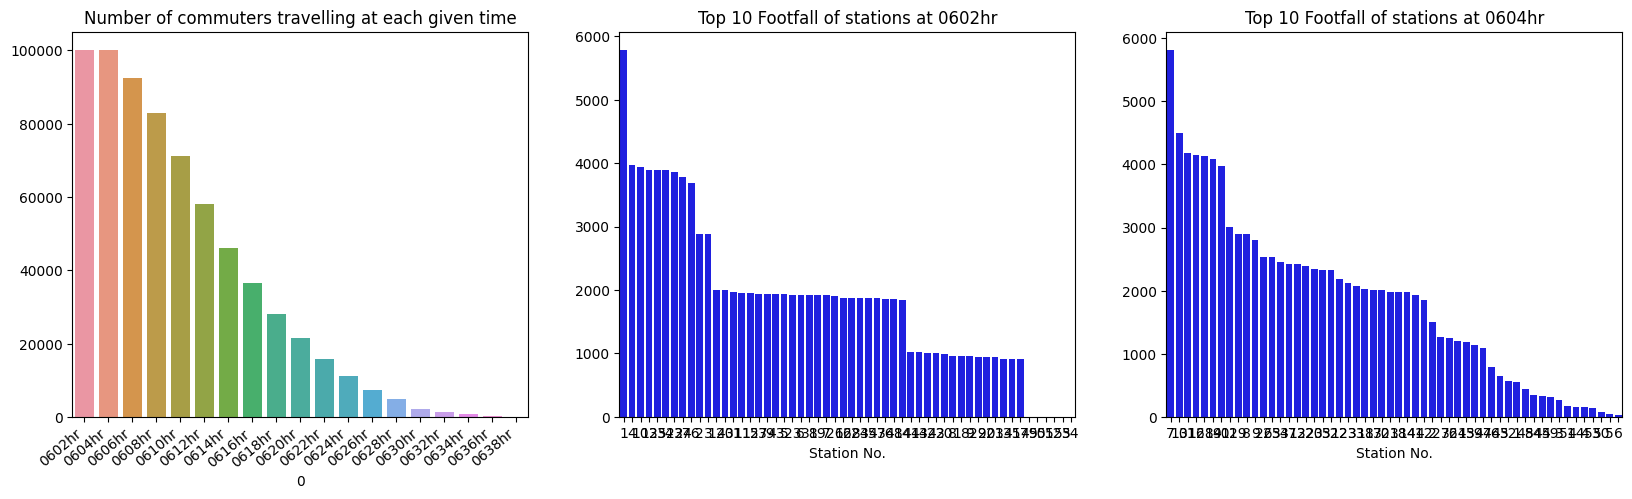

In [ ]:
#number of commuters travelling at each given time
df_freq_ppl = df_time_obj5.apply(pd.Series.value_counts).sum()

fig, ax = plt.subplots(1,3, figsize=(20, 5))
p1 = sns.barplot(x=df_freq_ppl.index, y=df_freq_ppl.values, ax=ax[0])
sns.barplot(x=list(hr602.keys()), y=list(hr602.values()), ax=ax[1], order = list(hr602.keys()), color='blue').set_title('Top 10 Footfall of stations at 0602hr')
sns.barplot(x=list(hr604.keys()), y=list(hr604.values()), ax=ax[2], order = list(hr604.keys()), color='b').set_title('Top 10 Footfall of stations at 0604hr')


ax[0].set_xticklabels(p1.get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Number of commuters travelling at each given time')

ax[1].set(xlabel='Station No.')
ax[2].set(xlabel='Station No.')

plt.show()

**Human traffic for the entire MRT system FIG. 1**

This is information about the culmulative footfall over a range of time (left) or the footfall at a given time (middle & right). Likewise, data on cumulative footfall can help station managers plan and allocate resources such as staff, security, and maintenance, based on the level of traffic the station experiences over time. For example, if a station experiences a significant increase in footfall over a period of time, the station may need to allocate more resources to ensure that the it can handle the increased traffic effectively. With the knowledge that at 0602 and 0604 all commuters are travelling concurrently, we can then look at the footfall of the busiest stations at each time.



**Footfall at each specific timing FIG.2/3**

From fig 2, we can see that at 0602 station 1 has the highest footfall of 5778 while from fig 3, we can see that at 0604 station 7 has the highest footfall of 5807.

Additionally, at both peak periods of 0602 & 0604, the average number of commuters at each station are 1851.851851851852

**Journey completion timeframe FIG.1**

It can also be seen that within the first 10 mins, roughly 42% of the passengers have reached their destinations and are not within the MRT network and within the next 10 mins, around 98% of the passengers have ended their journey

In [ ]:
hr602_ave = sum(hr602.values()) / float(len(hr602))
hr604_ave = sum(hr604.values()) / float(len(hr604))

**Human Traffic for the separate components**

With the set of stations obtained in the previous part, we are also able to differentiate the load and volume of passengers within each components.

Set of nodes in component 1: {1, 2, 3, 7, 8, 9, 13, 14, 15, 19, 20, 21, 25, 26, 27, 31, 32, 33, 37, 38, 39, 43, 44, 45, 49, 50, 51}

Set of nodes in component 2: {4, 5, 6, 10, 11, 12, 16, 17, 18, 22, 23, 24, 28, 29, 30, 34, 35, 36, 40, 41, 42, 46, 47, 48, 52, 53, 54}

In [ ]:
comp1 = [1, 2, 3, 7, 8, 9, 13, 14, 15, 19, 20, 21, 25, 26, 27, 31, 32, 33, 37, 38, 39, 43, 44, 45, 49, 50, 51]
comp2 = [4, 5, 6, 10, 11, 12, 16, 17, 18, 22, 23, 24, 28, 29, 30, 34, 35, 36, 40, 41, 42, 46, 47, 48, 52, 53, 54]
comp1 = [str(x) for x in comp1]
comp2 = [str(x) for x in comp2]

#filter commuters based on components
df_1 = df[df['0602hr'].isin(comp1)]
df_2 = df[df['0602hr'].isin(comp2)]

print(f'We can see that the commuters are equally distributed with {len(df_1)} in each components')

hr602_c1 = freq_stations(df_1, start, end, 10, reverse, occupation)
hr602_c2 = freq_stations(df_2, 602, 602, 10, reverse, occupation)

We can see that the commuters are equally distributed with 50000 in each components


In [ ]:
hr602_c1

{1: 5778,
 13: 3898,
 25: 3888,
 37: 3784,
 2: 2886,
 3: 2880,
 31: 1961,
 15: 1947,
 27: 1940,
 39: 1938}

This is the number of people at each station at 602hr for component 1, where n_leargest is 10.

In [ ]:
hr604_c1_t = freq_stations(df_1, 604, 604, 54, reverse, occupation)
hr604_c1_t

{7: 5807,
 31: 4182,
 19: 4091,
 8: 2895,
 9: 2796,
 26: 2537,
 25: 2529,
 37: 2429,
 13: 2426,
 20: 2348,
 32: 2327,
 33: 2066,
 21: 1985,
 38: 1979,
 14: 1972,
 2: 1498,
 27: 1273,
 15: 1186,
 39: 1143,
 43: 650,
 1: 550,
 45: 338,
 49: 312,
 3: 267,
 51: 173,
 44: 162,
 50: 79,
 4: 0,
 5: 0,
 6: 0,
 10: 0,
 11: 0,
 12: 0,
 16: 0,
 17: 0,
 18: 0,
 22: 0,
 23: 0,
 24: 0,
 28: 0,
 29: 0,
 30: 0,
 34: 0,
 35: 0,
 36: 0,
 40: 0,
 41: 0,
 42: 0,
 46: 0,
 47: 0,
 48: 0,
 52: 0,
 53: 0,
 54: 0}

This is the dictionary for component 1 at time 604

In [ ]:
hr604_c1 = freq_stations(df_1, 604, 604, 10, reverse, occupation)
hr604_c2 = freq_stations(df_2, 604, 604, 10, reverse, occupation)

hr606_c1 = freq_stations(df_1, 606, 606, 10, reverse, occupation)
hr606_c2 = freq_stations(df_2, 606, 606, 10, reverse, occupation)

hr602_6_c1 = freq_stations(df_1, 602, 606, 10, reverse, occupation)
hr602_6_c2 = freq_stations(df_2, 602, 606, 10, reverse, occupation)


In [ ]:
hr602_6_c2

{22: 11332,
 34: 11277,
 16: 9748,
 10: 9604,
 28: 8088,
 35: 7302,
 23: 7218,
 40: 6749,
 29: 6630,
 11: 6626}

Next with we can visually the above result by plotting the top 10 highest traffic stations at 0602hr and 0604hr for the different components

Text(0.5, 1.0, 'Top 10 Culmulative Footfall of stations at from 0602hr to 0606hr for C2')

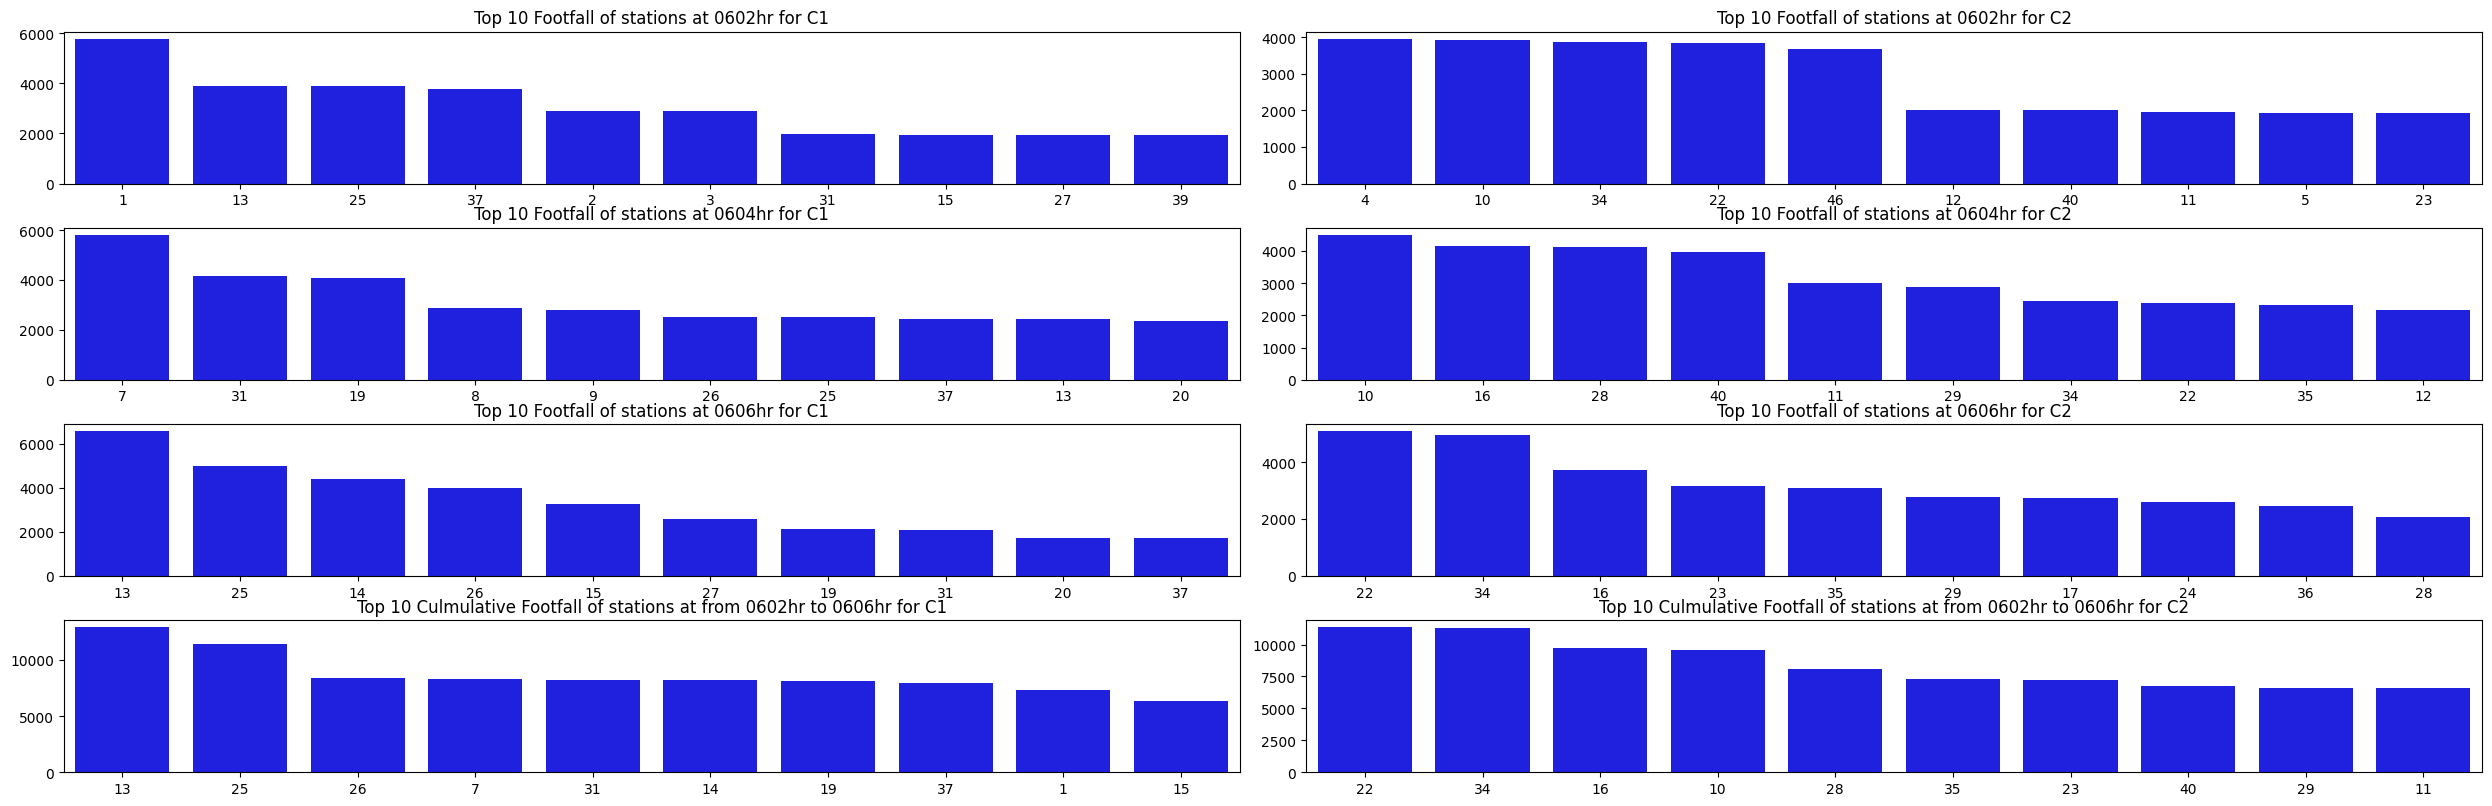

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(25, 8))
fig.tight_layout()
sns.barplot(x=list(hr602_c1.keys()), y=list(hr602_c1.values()), ax=ax[0][0], order = list(hr602_c1.keys()), color='blue').set_title('Top 10 Footfall of stations at 0602hr for C1')
sns.barplot(x=list(hr602_c2.keys()), y=list(hr602_c2.values()), ax=ax[0][1], order = list(hr602_c2.keys()), color='b').set_title('Top 10 Footfall of stations at 0602hr for C2')

sns.barplot(x=list(hr604_c1.keys()), y=list(hr604_c1.values()), ax=ax[1][0], order = list(hr604_c1.keys()), color='blue').set_title('Top 10 Footfall of stations at 0604hr for C1')
sns.barplot(x=list(hr604_c2.keys()), y=list(hr604_c2.values()), ax=ax[1][1], order = list(hr604_c2.keys()), color='b').set_title('Top 10 Footfall of stations at 0604hr for C2')

sns.barplot(x=list(hr606_c1.keys()), y=list(hr606_c1.values()), ax=ax[2][0], order = list(hr606_c1.keys()), color='blue').set_title('Top 10 Footfall of stations at 0606hr for C1')
sns.barplot(x=list(hr606_c2.keys()), y=list(hr606_c2.values()), ax=ax[2][1], order = list(hr606_c2.keys()), color='b').set_title('Top 10 Footfall of stations at 0606hr for C2')

sns.barplot(x=list(hr602_6_c1.keys()), y=list(hr602_6_c1.values()), ax=ax[3][0], order = list(hr602_6_c1.keys()), color='b').set_title('Top 10 Culmulative Footfall of stations at from 0602hr to 0606hr for C1')
sns.barplot(x=list(hr602_6_c2.keys()), y=list(hr602_6_c2.values()), ax=ax[3][1], order = list(hr602_6_c2.keys()), color='b').set_title('Top 10 Culmulative Footfall of stations at from 0602hr to 0606hr for C2')

**Component 1**

From the plots of component 1 (left fig), we can see that in a span of 6 mins, station 13 has a culmulative traffic of 12911. This is could suggest that station 13 could be a large housing estate and also an interchange, which is supported by the network diagram where station 13 has a degree of 3.

Another interesting point is that within 2 mins from 0602, station 1 has fallen from the top spot with 5778 passengers at 0602 to 550 passengers at 0602.

**Component 2**

From the plots of component 2 (right fig), we can see that within 6 mins, station 22 has accumulated a footfall of 11332. With reference to the network diagram, we can confirm that station 22 is also an interchange with a degree of 3.

---------------------------------------------
With the information generated from above, here are a few suggestions to improve commuter's experience.

1. Increase capacity at station 13. Since station 13 has a high footfall and is potentially a large housing estate and interchange, there could be an increase in the number of trains or platforms to accommodate the commuter traffic during peak hours.

2. Increase frequency of trains at station 1. Station 1 has fallen from the top spot within a span of 2 minutes, indicating that commuters may be avoiding this station due to overcrowding. Increasing the frequency of trains during peak hours could help alleviate this issue and improve the overall experience for commuters.


For the next part, we will look at the stations with no passengers at each given time

In [ ]:
import math
# finding stations that have no footfall at each given time
comp1 = [1, 2, 3, 7, 8, 9, 13, 14, 15, 19, 20, 21, 25, 26, 27, 31, 32, 33, 37, 38, 39, 43, 44, 45, 49, 50, 51]
comp2 = [4, 5, 6, 10, 11, 12, 16, 17, 18, 22, 23, 24, 28, 29, 30, 34, 35, 36, 40, 41, 42, 46, 47, 48, 52, 53, 54]
timings = df_time_obj5.columns.tolist()
df_agg = df_time_obj5.apply(pd.Series.value_counts)
num_empty_stns = []
print("Entire MRT network")

for i in timings:
    num_empty = df_time_obj5.apply(pd.Series.value_counts)[i].isna().sum()
    num_empty_stns.append(num_empty)
    index = df_agg[i].index[df_agg[i].apply(pd.isna)].tolist()
    print(f'{i}: {num_empty}, stations: {index}')


df_time_1 = df_time_obj5[df_time_obj5['0602hr'].isin(comp1)]
df_time_2 = df_time_obj5[df_time_obj5['0602hr'].isin(comp2)]
df_agg_1 = df_time_1.apply(pd.Series.value_counts)
df_agg_2 = df_time_2.apply(pd.Series.value_counts)

num_empty_stns_1 = []
print("Component 1")
for i in timings:
    num_empty = df_time_1.apply(pd.Series.value_counts)[i].isna().sum()
    num_empty_stns_1.append(num_empty)
    index = df_agg_1[i].index[df_agg_1[i].apply(pd.isna)].tolist()
    print(f'{i}: {num_empty}, stations: {index}')

num_empty_stns_2 = []
print("Component 2")
for i in timings:
    num_empty = df_time_2.apply(pd.Series.value_counts)[i].isna().sum()
    num_empty_stns_2.append(num_empty)
    index = df_agg_2[i].index[df_agg_2[i].apply(pd.isna)].tolist()
    print(f'{i}: {num_empty}, stations: {index}')


Entire MRT network
0602hr: 6, stations: [49, 50, 51, 52, 53, 54]
0604hr: 0, stations: []
0606hr: 0, stations: []
0608hr: 0, stations: []
0610hr: 0, stations: []
0612hr: 0, stations: []
0614hr: 0, stations: []
0616hr: 0, stations: []
0618hr: 0, stations: []
0620hr: 0, stations: []
0622hr: 2, stations: [50, 53]
0624hr: 6, stations: [49, 50, 51, 52, 53, 54]
0626hr: 6, stations: [49, 50, 51, 52, 53, 54]
0628hr: 8, stations: [35, 41, 49, 50, 51, 52, 53, 54]
0630hr: 16, stations: [26, 29, 32, 34, 35, 36, 40, 41, 42, 47, 49, 50, 51, 52, 53, 54]
0632hr: 27, stations: [20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 42, 46, 47, 48, 49, 50, 51, 52, 53, 54]
0634hr: 36, stations: [14, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54]
0636hr: 44, stations: [8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 

The printed output shows at what time and its correspondong stations with no crowd for the entire network, component 1 and 2 respectively.

For instance, when looking at the output of component 2, we can see that at 0604hr, all stations have at least 1 person, while at 0638hr, the list stated are the stations with no crowd.

The same assumptions still apply where the crowd represents alighting/boarding and transiting through the station.

<ipython-input-825-e9a3429bfb4d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


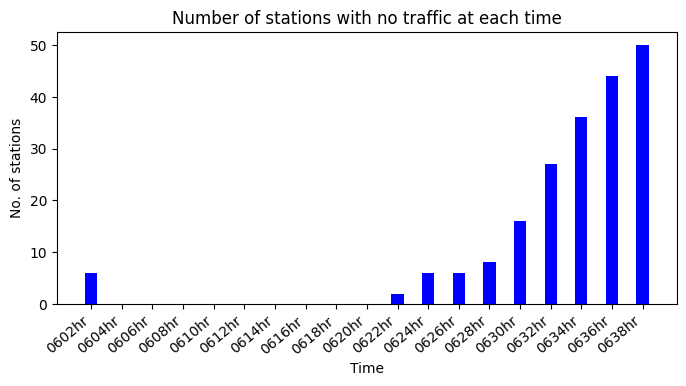

In [ ]:
fig, ax= plt.subplots(1, figsize = (8, 4))

# creating the bar plot
fig.autofmt_xdate()
plt.bar(timings, num_empty_stns, color ='blue',width = 0.4)

plt.xlabel("Time")
plt.ylabel("No. of stations")
plt.title("Number of stations with no traffic at each time")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

* Cost optimization: If the station is owned by a transit authority or a private operator, identifying stations with low or no footfall can help them to optimize their resources and reduce their operating costs. This could involve reallocating staff or reducing services, such as cleaning, security, or maintenance, in stations where footfall is low.

* Infrastructure planning: The data on stations with low or no footfall can be useful in informing decisions on future transport infrastructure investment and planning. For instance, the data can help identify areas that may be underserved by public transport and require new transport infrastructure investments to improve accessibility.

---------------------------------------------
Next, we will look at the travel patterns by the demographic

In [ ]:
#travel patterns by demographic
occupation = "student"
gender = ""
start_end = -1

def travel_pattern(occupation, gender, start_end):
  stn_dict = {}
  lst_stations = range(1,55)
  #initialise dict
  for s in lst_stations:
      stn_dict[s] = 0

  if len(occupation)>0 and len(gender)>0:
      sub_df = df[(df["Occupation"]==occupation) & (df["Gender"]==gender)]
      df_time_obj5 = sub_df.drop(columns=['commuter', 'Gender', 'Occupation'])
      # df_time = df_time.astype('Int64')
  elif occupation:
      sub_df = df[(df["Occupation"]==occupation)]
      df_time_obj5 = sub_df.drop(columns=['commuter', 'Gender', 'Occupation'])
      # df_time = df_time.astype('Int64')
  elif gender:
      sub_df = df[(df["Gender"]==gender)]
      df_time_obj5 = sub_df.drop(columns=['commuter', 'Gender', 'Occupation'])
      # df_time = df_time.astype('Int64')
  else:
      df_time_obj5 = df.drop(columns=['commuter', 'Gender', 'Occupation'])
      # df_time = df_time.astype('Int64')

  for i in range(len(df_time_obj5)):
      stns = [x for x in list(df_time_obj5.iloc[i].values) if str(x)!='null']
      stn_dict[int(stns[start_end])]+=1


  # new_dict = {k:v for k,v in stn_dict.items() if v != 0}
  # print(f'starting or ending location: {start_end},{occupation}, {gender}, {sorted_dict}')
  return dict(sorted(stn_dict.items(), key=lambda item: item[1], reverse=True))

student_ending = travel_pattern(occupation, gender, -1)
student_starting = travel_pattern(occupation, gender, 0)


politician_ending = travel_pattern("politician", gender, -1)
politician_starting =  travel_pattern("politician", gender, 0)

worker_ending = travel_pattern("worker", gender, -1)
worker_starting =  travel_pattern("worker", gender, 0)

In [ ]:
student_starting_male = travel_pattern(occupation, "male", 0)
student_starting_female = travel_pattern(occupation, "female", 0)

In [ ]:
politician_ending_male = travel_pattern("politician", "male", -1)
politician_starting_male =  travel_pattern("politician", "male", 0)

politician_ending_female = travel_pattern("politician", "female", -1)
politician_starting_female =  travel_pattern("politician", "female", 0)

In [ ]:
worker_ending_male = travel_pattern("worker", "male", -1)
worker_starting_male =  travel_pattern("worker", "male", 0)

worker_ending_female = travel_pattern("worker", "female", -1)
worker_starting_female =  travel_pattern("worker", "female", 0)

In [ ]:
all_ending = travel_pattern("", "", -1)
all_starting = travel_pattern("", "", 0)

Travel patterns of the commuter's starting and ending journeys based on their occupation.

**Students**:

* Regardless of gender all students (22306) end their journey at station 26.This suggests that the only school is located at station 26.
*   Students start their journey at various stations in component 1 and they only travel within component 1. Component 1 is where all the children stays and could be a district with a school. With 2740 of them staying at station 1 and 417 at 33.

**Workers**
* They start in various stations in both components 1 & 2, with the bulk also staying at station 1, suggesting that station 1 could be a large housing estate.
*The workers end at various stations within both components with the largest number (2516) of workers ending their journey at 26, could indicate that they're teachers. However, they end their journey at various stations.

**Politicians**
* They start their journey at various stations in both components 1 & 2 with the bulk of 2224 starting at station 4.
* Majority of the politicians end their journeys at station 29, which suggests that station 29 is near a political entity. Likewise to workers, their ending stations are also spreaded throughout different stations in both components.

**Misc**
* From the starting and ending stations of all commuters, we can see that commuters do not alight or board at stations 49, 50, 51, 52, 53 & 54.
* This might suggest that these stations are mainly used for interchange or are stations for other commuters not included in the dataset.



-------------
Next, we will look at the starting stations for every passenger to see where most of the passenger board from.

In [ ]:
all_starting

{1: 5778,
 4: 3964,
 10: 3933,
 13: 3898,
 25: 3888,
 34: 3886,
 22: 3859,
 37: 3784,
 46: 3682,
 2: 2886,
 3: 2880,
 12: 2004,
 40: 2000,
 31: 1961,
 11: 1957,
 15: 1947,
 27: 1940,
 39: 1938,
 43: 1934,
 5: 1931,
 23: 1927,
 6: 1924,
 38: 1924,
 19: 1921,
 7: 1915,
 26: 1900,
 16: 1882,
 28: 1878,
 24: 1877,
 35: 1875,
 47: 1870,
 36: 1861,
 48: 1858,
 14: 1844,
 41: 1023,
 44: 1017,
 32: 1009,
 42: 1001,
 30: 991,
 8: 961,
 18: 961,
 9: 956,
 29: 942,
 20: 940,
 21: 940,
 33: 920,
 45: 919,
 17: 914,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0}

In [ ]:
starting_c1 = {key: all_starting[key] for key in comp1}
starting_c2 = {key: all_starting[key] for key in comp2}

ending_c1 = {key: all_ending[key] for key in comp1}
ending_c2 = {key: all_ending[key] for key in comp2}

In [ ]:
df_time_str = df_time_obj5.astype(str)

In [ ]:
top10_start_c1 = dict(sorted(starting_c1.items(), key=lambda item: item[1], reverse=True)[:10])
top10_start_c1

{1: 5778,
 13: 3898,
 25: 3888,
 37: 3784,
 2: 2886,
 3: 2880,
 31: 1961,
 15: 1947,
 27: 1940,
 39: 1938}

In [ ]:
top10_start_c2 = dict(sorted(starting_c2.items(), key=lambda item: item[1], reverse=True)[:10])
top10_start_c2

{4: 3964,
 10: 3933,
 34: 3886,
 22: 3859,
 46: 3682,
 12: 2004,
 40: 2000,
 11: 1957,
 5: 1931,
 23: 1927}

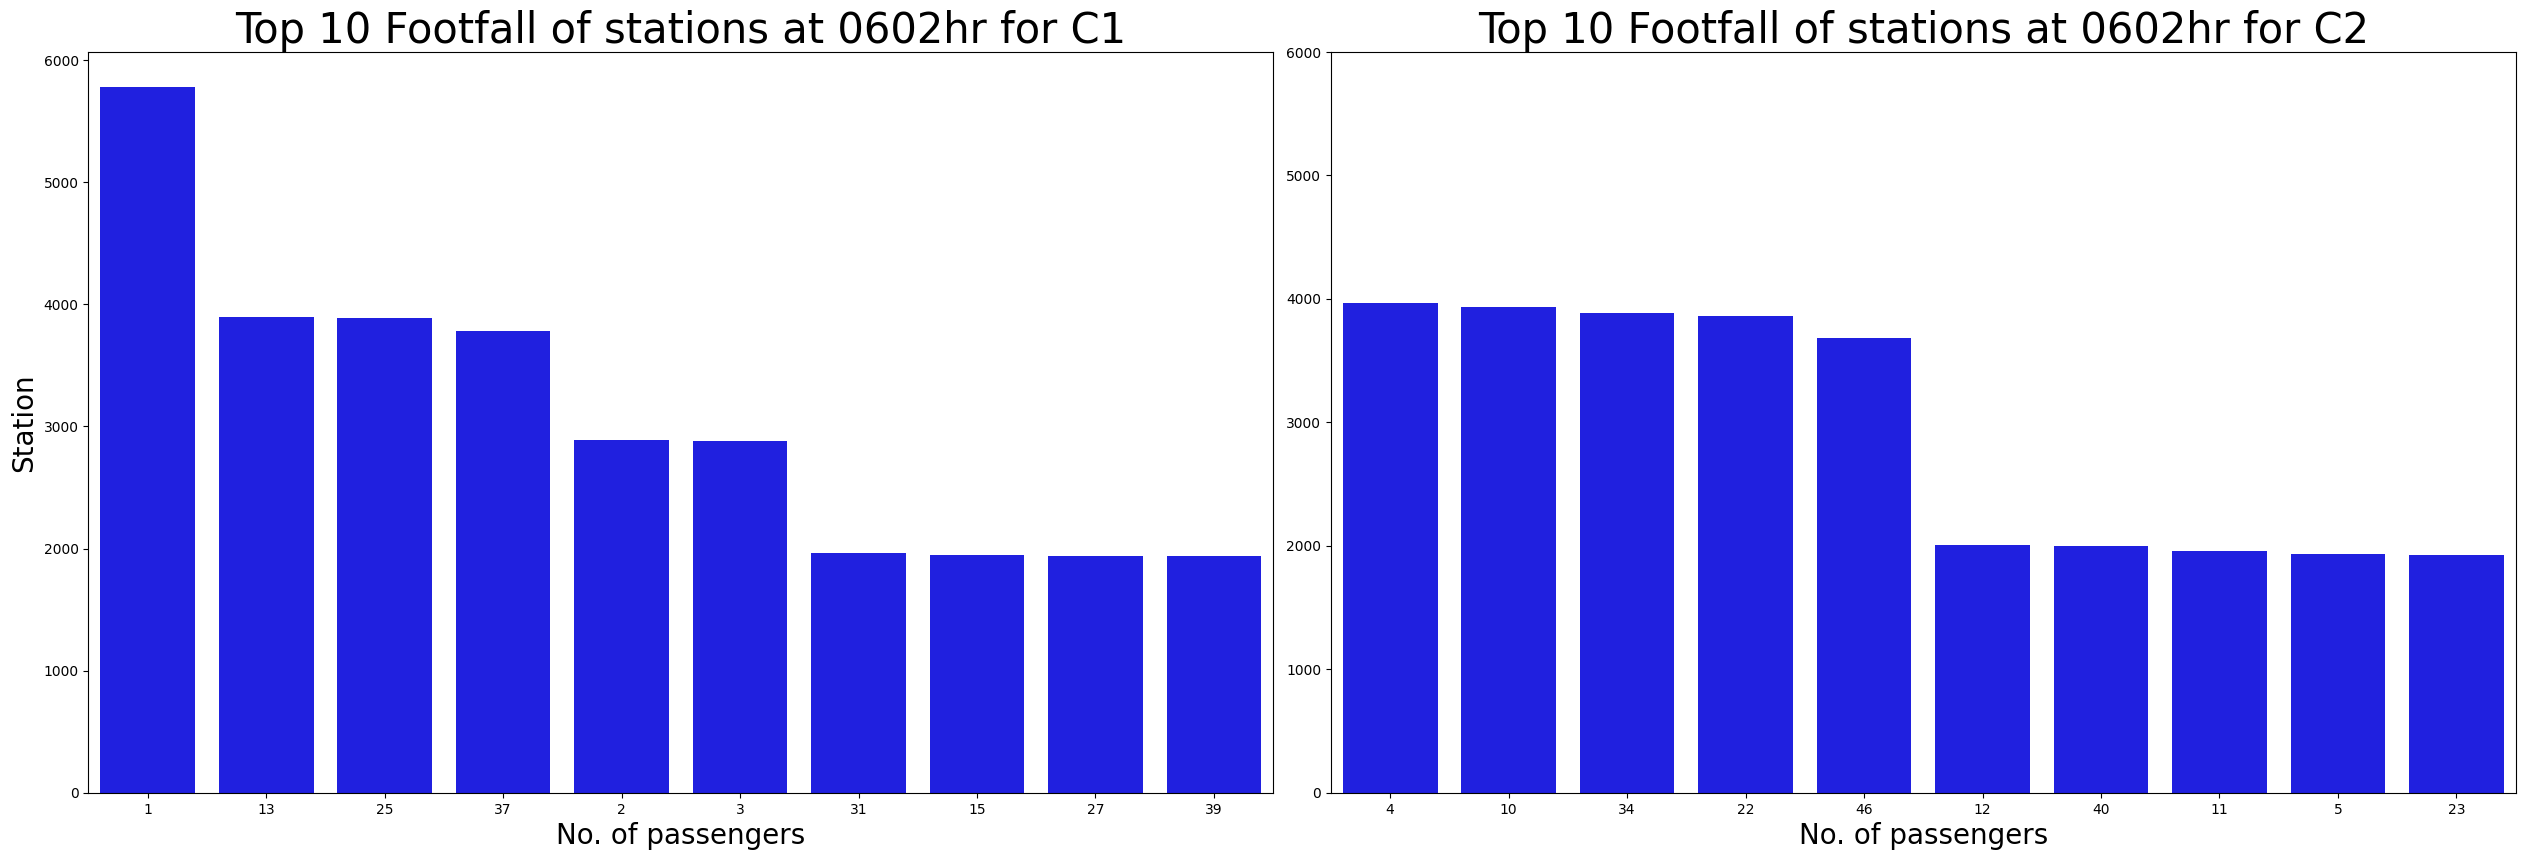

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))
fig.tight_layout()

plt.xticks(np.arange(0, 6000, 1000))
p1 = sns.barplot(x=list(top10_start_c1.keys()), y=list(top10_start_c1.values()), ax=ax[0], order = list(top10_start_c1.keys()), color='blue')#.set_title('Top 10 Footfall of stations at 0602hr for C1')
p2 = sns.barplot(x=list(top10_start_c2.keys()), y=list(top10_start_c2.values()), ax=ax[1], order = list(top10_start_c2.keys()), color='b')#.set_title('Top 10 Footfall of stations at 0602hr for C2')
p1.set_xlabel("No. of passengers", fontsize = 20)
p1.set_ylabel("Station", fontsize = 20)

p2.set_xlabel("No. of passengers", fontsize = 20)

p1.set_title('Top 10 Footfall of stations at 0602hr for C1', fontsize = 30)
p2.set_title('Top 10 Footfall of stations at 0602hr for C2', fontsize = 30)


plt.ylim(0, 6000)
plt.show()

From the given dataset, it can be seen that all passengers arrive at 602, hence we assume that they board the train at the respective stations.

From the barplot, we can see that station 1 and station 4 are the most boarded stations for component 1 and 2 respectively.

Likewise, suggestions such as making the station larger to increase room space for waiting and allocating more staff during that period for the aforementioned stations can be made to improve commuter's experience.

# **Objective 7**

Squaring or cubing the laplacian matrix can be used to analyse the impact of a fault at a particular station on the rest of the network. Specifically, it can be used to identify the stations that are most affected by a fault at the initial station (stations which are one step away).

If a fault occurs at a station (with high centrality measure), squaring the laplacian matrix can help identify which stations are directly connected to the affected station, while cubing the laplacian matrix can help identify which stations are indirectly affected by the fault. This information can then be used to develop contingency plans and alternative routes to minimise the impact of the fault on the network as a whole.

First get the normalised laplacian matrix of each component

In [ ]:
#diagonal matrix
D_1 = np.diag(np.sum(A_1, axis=1))
D_2 = np.diag(np.sum(A_2, axis=1))

#get laplacian
L_1 = D_1 - A_1
L_2 = D_2 - A_2

#get L_norm
from scipy.linalg import fractional_matrix_power
D_half_1 = fractional_matrix_power(D_1, -0.5)
L_norm_1 = D_half_1.dot(D_1-A_1).dot(D_half_1)

D_half_2 = fractional_matrix_power(D_2, -0.5)
L_norm_2 = D_half_2.dot(D_2-A_2).dot(D_half_2)

In [ ]:
print('------ Lnorm -----------')
for i in range(27):
    print(L_norm_1[i])

------ Lnorm -----------
[ 1.         -0.40824829  0.         -0.5         0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
[-0.40824829  1.         -0.40824829  0.         -0.40824829  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
[ 0.         -0.40824829  1.          0.          0.         -0.5
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
[-0.5         0.          0.          1.          0.          0.
 -0.40824829  0

Within each MRT component, select the station which has the highest betweenness centrality regardless of its clusters.

**Component 1**

In [ ]:
closeness_g1 = nx.betweenness_centrality(G_1) # Get the closeness centrality scores for every node in the cluster
node = max(closeness_g1, key=closeness_g1.get)
print(f'Station with highest betweenness centrality in C1 is {node}')

Station with highest betweenness centrality in C1 is 26


In [ ]:
index_19 = list(components[0]).index(19)

In [ ]:
x = [[0] * 27]
x[0][index_19] = 1
x = np.array(x).T

In [ ]:
Lnormx = L_norm_1 @ x
print('Lnormx ------')
print(Lnormx)

Lnormx ------
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.40824829]
 [ 0.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.40824829]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


In [ ]:
flat_list = [i for sublist in Lnormx for i in sublist]
lst_idx = [i for i, e in enumerate(flat_list) if e != 0]
stns_1step = []
for i in lst_idx:
  stns_1step.append(list(components[0])[i])

print(f'As expected, the non-zero values in Lnormx corresponds to the stations which are 1 step away. The stations are {stns_1step}. \nHence, stations {stns_1step} will be greatly affected as a direct consequence of a fault in station 19')

As expected, the non-zero values in Lnormx corresponds to the stations which are 1 step away. The stations are [13, 19, 25]. 
Hence, stations [13, 19, 25] will be greatly affected as a direct consequence of a fault in station 19


In [ ]:
Lnorm2x = L_norm_1 @ L_norm_1 @ x

flat_list_2 = [i for sublist in Lnorm2x for i in sublist]
lst_idx = [i for i, e in enumerate(flat_list_2) if e != 0]
stns_2step = []
for i in lst_idx:
  stns_2step.append(list(components[0])[i])
stns_2step_wo1 = [x for x in stns_2step if x not in stns_1step]
print(f'As expected, the non-zero values in Lnormx corresponds to the stations which are 2 steps away. The stations are {stns_2step_wo1}. \nHence, stations {stns_2step_wo1} will be greatly affected as a indirect consequence of a fault in station 19')

As expected, the non-zero values in Lnormx corresponds to the stations which are 2 steps away. The stations are [7, 14, 26, 31]. 
Hence, stations [7, 14, 26, 31] will be greatly affected as a indirect consequence of a fault in station 19


**Component 2**

In [ ]:
closeness_g2 = nx.betweenness_centrality(G_2) # Get the closeness centrality scores for every node in the cluster
node = max(closeness_g2, key=closeness_g2.get)
print(f'Station with highest betweenness centrality in C2 is {node}')

Station with highest betweenness centrality in C2 is 23


In [ ]:
index_28 = list(components[1]).index(28)
x = [[0] * 27]
x[0][index_28] = 1
x = np.array(x).T

In [ ]:
Lnormx = L_norm_2 @ x
print('Lnormx ------')
print(Lnormx)

Lnormx ------
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.40824829]
 [ 0.        ]
 [ 0.        ]
 [ 1.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.40824829]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


In [ ]:
flat_list = [i for sublist in Lnormx for i in sublist]
lst_idx = [i for i, e in enumerate(flat_list) if e != 0]
stns_1step = []
for i in lst_idx:
  stns_1step.append(list(components[1])[i])

print(f'As expected, the non-zero values in Lnormx corresponds to the stations which are 1 step away. The stations are {stns_1step}. \nHence, stations {stns_1step} will be greatly affected as a direct consequence of a fault in station 28')

As expected, the non-zero values in Lnormx corresponds to the stations which are 1 step away. The stations are [22, 28, 34]. 
Hence, stations [22, 28, 34] will be greatly affected as a direct consequence of a fault in station 28


In [ ]:
Lnorm2x = L_norm_2 @ L_norm_2 @ x

flat_list_2 = [i for sublist in Lnorm2x for i in sublist]
lst_idx = [i for i, e in enumerate(flat_list_2) if e != 0]
stns_2step = []
for i in lst_idx:
  stns_2step.append(list(components[1])[i])
stns_2step_wo1 = [x for x in stns_2step if x not in stns_1step]
print(f'As expected, the non-zero values in Lnormx corresponds to the stations which are 2 steps away. The stations are {stns_2step_wo1}. \nHence, stations {stns_2step_wo1} will be greatly affected as a indirect consequence of a fault in station 28')

As expected, the non-zero values in Lnormx corresponds to the stations which are 2 steps away. The stations are [16, 23, 35, 40]. 
Hence, stations [16, 23, 35, 40] will be greatly affected as a indirect consequence of a fault in station 28


Set of nodes in component 1: {1, 2, 3, 7, 8, 9, 13, 14, 15, 19, 20, 21, 25, 26, 27, 31, 32, 33, 37, 38, 39, 43, 44, 45, 49, 50, 51}

Set of nodes in component 2: {4, 5, 6, 10, 11, 12, 16, 17, 18, 22, 23, 24, 28, 29, 30, 34, 35, 36, 40, 41, 42, 46, 47, 48, 52, 53, 54}